# Predictive Modelling of Commute Method Preferences by Demographic Data[<sup>⋆</sup>](#fnt)
Swarnim Madan <br>
<span id='af1'><i>Macquarie University</i><br></span>
_______________<br>
This work was completed as coursework for COMP2200 - Data Science

## Aim <br>

The overall goal for this project is to determine the effect of population demographics on the mode of transport the general populace uses.

The datasets used are provided by Transport NSW - https://opendata.transport.nsw.gov.au/search/type/dataset


## Structure

1. Library Imports and Options
2. Functions
3. Introduction
4. Datasets<br>
 4.1 Method of Commute Data<br>
    &nbsp; 4.1.1 Method of Commute by Usual Residence<br>
 4.2 Personal Characteristics Data<br>
  &nbsp;4.2.1 Age Group by Usual Residence<br>
  &nbsp;4.2.2 Gender by Usual Residence<br>
 4.3 Employment Characteristics Data<br>
  &nbsp;4.3.1 Occupation by Usual Residence<br>
  &nbsp;4.3.2 Industry by Usual Residence<br>
  &nbsp;4.3.3 Total Weekly Personal Income by Usual Residence<br>
 4.4 Geographic Characteristics Data<br>
  &nbsp;4.4.1 Distance To Work by Usual Residence<br>
  &nbsp;4.4.2 Place of Work by Usual Residence<br>
 4.5 Supplementary Datasets <br>
  &nbsp;4.5.1 ASGS SA2 to Postcode Correspondence Data<br>
  &nbsp;4.5.2 Australian Postcode Location Data<br>
5. Dataset Preparation <br>
 5.1 Assigning Coordinates to Usual Residence Areas<br>
 5.2 Creating combined dataframe by Usual Residence<br>
6. Dataset Exploration<br>
 6.1 Spatial Visualisations<br>
 6.2 Distributions<br>
  &nbsp; 6.2.1 Distribution of Method of Commute<br>
  &nbsp; 6.2.2 Distribution of Personal Characteristics<br>
  &nbsp; 6.2.3 Distribution of Employment Characteristics<br>
  &nbsp; 6.2.4 Distribution of Geographic Characteristics<br>
 6.3 Correlations<br>
  &nbsp; 6.3.1 Overall Correlations between All Features<br>
  &nbsp; 6.3.2 Correlations between Commuting Method and Personal Characteristics<br>
  &nbsp; 6.3.3 Correlations between Commuting Method and Employment Characteristics<br>
  &nbsp; 6.3.4 Correlations between Commuting Method and Geographic Characteristics<br>
7. Modelling<br>
 7.1 Preparing Training and Testing Data Sets<br>
 7.2 Baseline Performances<br>
  &nbsp; 7.2.1. Linear Regression<br>
  &nbsp; 7.2.2 Random Forest Regression<br>
  &nbsp; 7.2.3 Decision Tree Regression<br>
  &nbsp; 7.2.4. KNeighbors Regression<br>
  &nbsp; 7.2.5 Comparison<br>
 7.3 Model Refinement by Recursive Feature Elimination<br>
  &nbsp; 7.3.1. Recursive Feature Elimination<br>
  &nbsp; 7.3.2 Cross Validated Recursive Feature Elimination<br>
8. Model Evaluation<br>
9. Conclusions<br>


***

## 1. Library Imports and Options

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import RFE, RFECV

In [13]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.options.display.max_columns = None
sns.set_context('notebook',font_scale=1.5,rc={'lines.linewidth':1.2})
sns.set_style('ticks')
sns.set_palette('deep')
plt.rcParams['figure.autolayout'] = 1

## 2. Functions

In [14]:
# function to quickly inspect a dataframe:
def inspect(df):
    display(df.dtypes)
    display(df)
    display(df.describe())

In [15]:
# function to create regression plot grid 
def regplots(predicted,predictor):
    #print('paused')
    f, axes = plt.subplots(len(predictor),len(predicted), sharex='col', sharey='row', figsize=(12,len(predictor)*(12/(len(predicted)))))
    for i, col in enumerate(predicted):
        for j, col2 in enumerate(predictor):
            sns.regplot(y=predictor[j],x=predicted[i],data=datapc,ax=axes[j,i],color='k',marker='+',line_kws=dict(color='r'), truncate=True)
            axes[j,i].set(ylabel=None)
            axes[j,i].set(xlabel=None)
            axes[j,i].set_yticklabels(axes[j,i].get_yticks(),fontsize=10)
            axes[j,i].set_xticklabels(axes[j,i].get_xticks(),fontsize=10)
    for ax, col in zip(axes[0],predicted):
        ax.set_title(col)
    for ax, row in zip(axes[:,0],predictor):
        ax.set_ylabel(row, rotation=90, size=20)
    f.subplots_adjust(hspace=0, wspace=0)

In [16]:
# function to print with markdown
def printmd(string):
    display(Markdown(string))

In [17]:
# function to display model scores
def scores(hat,truth,cols):
    rmse=np.append(np.sqrt(mean_squared_error(truth, hat, multioutput='raw_values')), np.sqrt(mean_squared_error(truth, hat, multioutput='uniform_average')))
    r2=np.append(r2_score(truth, hat, multioutput='raw_values'), r2_score(truth, hat, multioutput='uniform_average'))
    mae=np.append(mean_absolute_error(truth, hat, multioutput='raw_values'), mean_absolute_error(truth, hat, multioutput='uniform_average'))
    out=pd.DataFrame([rmse,r2,mae],columns=cols+['Uniform Average'],index=['RMSE','R2','MAE']).round(decimals=2)
    display(out)
    return out

***
## 3. Introduction

In recent years, many local councils in Sydney have transitioned towards high-density development planning in an effort to better accommodate a fast growing population. This is expected to lead to an overall increase in public transport patronage, as traditional ideas of private car ownership and usage are discouraged by increasingly pedestrianised urban designs. In order to ensure public transportation systems and road infrastructure can adequately adapt to increased usage, planning and scheduling decisions must be made with an appropriate understanding of patron preferences and behaviour.

This study utilises data from the 2016 Population Census (Australian Bureau of Statistics) to discern relationships between the proportion of commute method users, and the demographic attributes of residents in particular geographical area. Relationships between preferred modes of transportation, personal attributes, employment attributes and geographic attributes are investigated and modelled. 

The overarching intent of the study is to facilitate informed infrastructure planning and scheduling decisions by identifying patterns of transportation usage behaviour in the mentioned datasets. Of specific interest are any trends based on the attributes of age, employment, place of residence and place of work. Ideally, this analysis will be able to ultimately inform future urban planning in a fast growing city. It is envisioned that a model can be prepared to receive data directly from the upcoming 2021 Population.

***

## 4. Datasets

### 4.1 Method of Commute Data  <a class='anchor' id='2.1.1'></a>

*Source: Australian Bureau of Statistics*  
This dataset tabulates the number of people using each method of commute in various SA2 statistical areas in Sydney based on the 2016 Population Census.
Column names are altered for ease of handling while certain irrelevant columns are dropped. The data is recalculated as percentages of the remaining columns.
Because the objective of this study is to aid in infrastructure planning, 'Car, as passenger' is summed with 'Car, as driver' to form a combined column 'Car'.
'Taxi', 'Truck', 'Other Method', 'Worked at home', 'Did not go to work', 'Not stated' and 'Not applicable' columns have been excluded as they not considered to be relevant to the study.

#### 4.1.1 Method of Commute by Usual Residence

##### Supplementary information
count: Count of N/A values. <br>
mean: Mean of the values.<br>
min: Minimum value. <br>
max: Maximum value. <br>
std: Standard Deviation. <br>
25%, 50%, 75%: Percentiles. <br>

In [18]:
# import data as dataframe Method of travel to work by usual residence (SA2), dropping unnecessary columns and NaN values
mtwUR = pd.read_csv('data/MTWUR.csv',skiprows=10,nrows=284).drop(columns=['Worked at home','Did not go to work','Not stated','Not applicable','Unnamed: 18','Total','Other Mode','Truck','Taxi']).dropna()

# combine car, as driver and car, as passenger into a single column by summation
mtwUR['Car'] = mtwUR['Car, as driver'] + mtwUR['Car, as passenger']
mtwUR = mtwUR.drop(columns=['Car, as driver','Car, as passenger'])

# rename columns for easier handling
mtwUR.rename(columns={'Motorbike/scooter':'Motorcycle','Walked only':'Walk'}, inplace=1)

# inspect data
#inspect(mtwUR)

# create copy of data expressed as percentages
mtwURpc = mtwUR.copy()
mtws=['Train', 'Bus', 'Ferry', 'Tram', 'Car', 'Motorcycle', 'Bicycle', 'Walk']
mtwURpc[mtws] = mtwURpc[mtws].div(mtwURpc[mtws].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(mtwURpc)

MTW15P Method of Travel to Work (15 travel modes)     object
Train                                                float64
Bus                                                  float64
Ferry                                                float64
Tram                                                 float64
Motorcycle                                           float64
Bicycle                                              float64
Walk                                                 float64
Car                                                  float64
dtype: object

MTW15P Method of Travel to Work (15 travel modes)      Train       Bus  \
1                               Baulkham Hills (East)   2.418842  4.837683   
2                 Baulkham Hills (West) - Bella Vista   2.281071  3.813207   
3                                           Glenhaven   0.684932  1.369863   
4                                  West Pennant Hills   6.001091  2.836879   
5                               Castle Hill - Central   1.501661  3.375415   
..                                                ...        ...       ...   
279                             Sutherland - Kirrawee   7.610968  0.590188   
280                                          Engadine   6.729533  0.857265   
281                              Loftus - Yarrawarrah   6.557377  0.000000   
282                                  Woronora Heights  10.743802  0.000000   
283                                             Total  20.215082  7.727490   

        Ferry      Tram  Motorcycle   Bicycle       Walk        Car  
1    0.190961  0.000000    0.509230  0.095481   2.737110  89.210694  
2    0.019580  0.000000    0.430760  0.264330   0.949630  92.241422  
3    0.000000  0.000000    0.684932  0.000000   3.424658  93.835616  
4    0.000000  0.000000    0.872886  0.381888   1.145663  88.761593  
5    0.000000  0.000000    0.558140  0.292359   0.837209  93.435216  
..        ...       ...         ...       ...        ...        ...  
279  0.000000  0.061478    0.663962  0.713144   3.270626  87.089635  
280  0.000000  0.000000    0.128590  0.257180   6.386627  85.640806  
281  0.000000  0.000000    0.000000  1.170960   3.512881  88.758782  
282  0.000000  0.000000    0.000000  0.000000  14.049587  75.206612  
283  0.504421  0.175569    0.807016  0.907325   4.992906  64.670191  

[283 rows x 9 columns]

Train         Bus       Ferry        Tram  Motorcycle     Bicycle  \
count  282.000000  282.000000  282.000000  282.000000  282.000000  282.000000   
mean     8.085622    3.587536    0.083142    0.051708    0.595568    0.575651   
std      8.508442    3.680402    0.242604    0.241220    0.473902    0.661733   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.297193    1.249763    0.000000    0.000000    0.289165    0.190304   
50%      5.840951    2.211820    0.000000    0.000000    0.513538    0.377831   
75%     10.098699    4.538810    0.059639    0.031965    0.778534    0.703047   
max     53.697110   21.403698    2.599031    3.496126    2.701770    4.159818   

             Walk         Car  
count  282.000000  282.000000  
mean     4.853644   82.167129  
std      3.267650   13.869755  
min      0.000000   13.465886  
25%      2.527246   78.126377  
50%      4.105239   85.857439  
75%      6.410060   91.330565  
max     20.349018  100.000000

### 4.2 Personal Characteristics Data

*Source: Australian Bureau of Statistics*  
These datasets contain gender and age group proportions in various SA2 statistical areas in Sydney based on the 2016 Population Census. Column names are altered for ease of handling while certain irrelevant columns are dropped. The data is recalculated as percentages of the remaining columns.

#### 4.2.1 Age Group by Usual Residence 

In [22]:
# import data as dataframe containing age by usual residence (SA2), dropping unnecessary columns and NaN values
ageUR = pd.read_csv('data/AGEUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 20','Total']).dropna()

# rename columns for easier handling
ageUR.columns = ageUR.columns.str.replace(' years and over','').str.replace(' years','')
ageUR.rename(columns={'100':'100+'}, inplace=1)

# inspect data
#inspect(ageUR)

# create copy of data expressed as percentages
ageURpc = ageUR.copy()
ages=['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
ageURpc[ages] = ageURpc[ages].div(ageURpc[ages].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(ageURpc)

AGE5P - Age in Five Year Groups     object
15-19                              float64
20-24                              float64
25-29                              float64
30-34                              float64
35-39                              float64
40-44                              float64
45-49                              float64
50-54                              float64
55-59                              float64
60-64                              float64
65-69                              float64
70-74                              float64
75-79                              float64
80-84                              float64
85-89                              float64
90-94                              float64
95-99                              float64
100+                               float64
dtype: object

AGE5P - Age in Five Year Groups      15-19      20-24     25-29  \
1                  Baulkham Hills (East)   6.746275   5.853468  6.260811   
2    Baulkham Hills (West) - Bella Vista   9.447746   9.850173  6.500743   
3                              Glenhaven   8.419816   7.754063  4.993147   
4                     West Pennant Hills   9.333716   8.711469  6.212904   
5                  Castle Hill - Central   7.817158   6.343160  7.055316   
..                                   ...        ...        ...       ...   
279                Sutherland - Kirrawee   5.872073   6.338110  9.798439   
280                             Engadine   7.711825   6.004921  5.774258   
281                 Loftus - Yarrawarrah   7.632918   7.632918  6.158975   
282                     Woronora Heights  11.200807  10.359906  6.121763   
283                                Total   7.341464   8.822048  9.962132   

         30-34      35-39      40-44      45-49      50-54      55-59  \
1     9.575359  11.327493  10.903409   9.229396   7.393561   6.506333   
2     6.184993   8.023774   9.026746   9.187717   9.453938   8.624319   
3     3.309183   6.089681   7.009986   8.791854   8.498140   8.752692   
4     5.983151   6.720276   7.275512   7.859468   9.869807  10.156998   
5     9.108976  11.030142  10.135807   8.446505   7.469361   7.270619   
..         ...        ...        ...        ...        ...        ...   
279  10.549924   9.786788   8.965397   7.765350   7.310964   6.751719   
280   8.150085  10.564355  10.579732   8.918960   7.342765   6.696909   
281   6.755571   7.878575   9.914020   9.299877   8.650640   7.457449   
282   3.531786   5.852674   9.249916  11.032627  10.662630  11.839892   
283  10.252473   9.215441   8.743829   8.205430   7.765242   7.097617   

         60-64     65-69     70-74     75-79     80-84     85-89     90-94  \
1     6.004129  6.355672  5.250823  3.710730  2.349199  1.545673  0.859327   
2     7.559435  6.859832  4.179049  2.600297  1.423972  0.817236  0.198118   
3     8.204425  7.186215  6.814177  5.854709  4.131584  3.015469  0.939886   
4    10.051694  7.352096  4.901398  2.613441  1.225349  1.024316  0.583956   
5     6.359722  7.071878  5.018218  3.312355  1.954289  1.142763  0.314674   
..         ...       ...       ...       ...       ...       ...       ...   
279   5.790516  5.359431  4.590470  3.629267  3.011767  2.487475  1.502971   
280   5.981855  7.481163  6.819929  3.552207  2.237429  1.376288  0.676611   
281   8.264608  6.738024  5.386910  4.299000  2.210914  1.228286  0.350939   
282   9.048100  5.617222  2.690885  1.580895  0.538177  0.504541  0.000000   
283   6.075217  5.292014  3.894545  2.885054  2.102343  1.460072  0.700034   

        95-99      100+  
1    0.128341  0.000000  
2    0.043338  0.018574  
3    0.234972  0.000000  
4    0.124450  0.000000  
5    0.149056  0.000000  
..        ...       ...  
279  0.466038  0.023302  
280  0.076888  0.053821  
281  0.140376  0.000000  
282  0.168180  0.000000  
283  0.172164  0.012882  

[283 rows x 19 columns]

15-19       20-24       25-29       30-34       35-39       40-44  \
count  281.000000  281.000000  281.000000  281.000000  281.000000  281.000000   
mean     7.480097    8.408594    9.320046    9.619761    9.029406    8.653548   
std      3.007598    3.195237    4.496888    4.150845    2.952383    2.632307   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.136498    6.729964    6.538685    6.974916    7.586890    7.894405   
50%      7.684247    8.169697    8.691099    9.327818    8.670520    8.658491   
75%      9.064327    9.583815   11.129055   11.577708   10.247507    9.509284   
max     37.500000   26.971233   41.666667   28.571429   35.714286   35.714286   

            45-49       50-54       55-59       60-64       65-69       70-74  \
count  281.000000  281.000000  281.000000  281.000000  281.000000  281.000000   
mean     9.253473    7.899271    7.441397    6.036328    5.673099    3.926477   
std      9.660901    3.237803    3.950528    1.749468    3.563579    1.607380   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      7.567225    7.036054    6.422103    5.351841    4.404212    3.076923   
50%      8.332601    8.092341    7.270619    6.211151    5.418034    3.865359   
75%      9.229396    8.737142    8.122346    6.894028    6.434159    4.871187   
max    100.000000   50.000000   62.500000   10.504921   50.000000   12.500000   

            75-79       80-84       85-89       90-94       95-99        100+  
count  281.000000  281.000000  281.000000  281.000000  281.000000  281.000000  
mean     2.925108    2.049337    1.423863    0.680114    0.169904    0.010177  
std      1.410353    0.981496    0.890278    0.573252    0.181825    0.019605  
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
25%      2.199074    1.423972    0.850689    0.326995    0.063184    0.000000  
50%      2.874754    2.075055    1.320361    0.599892    0.136672    0.000000  
75%      3.584738    2.647787    1.886617    0.927293    0.223425    0.017358  
max     15.625000    7.007299    8.821689    6.569343    2.168926    0.119701

#### 4.2.2 Gender by Usual Residence 

In [23]:
# import data as dataframe containing gender by usual residence (SA2), dropping unnecessary columns and NaN values
sexUR = pd.read_csv('data/SEXUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 4']).dropna()

# inspect data
#inspect(sexUR)
# create copy of data expressed as percentages
sexURpc = sexUR.copy()
sexs=['Female', 'Male']
sexURpc[sexs] = sexURpc[sexs].div(sexURpc[sexs].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(sexURpc)

SEXP Sex     object
Female      float64
Male        float64
Total       float64
dtype: object

SEXP Sex     Female       Male      Total
1                  Baulkham Hills (East)  51.500949  48.499051    17922.0
2    Baulkham Hills (West) - Bella Vista  51.489810  48.510190    16144.0
3                              Glenhaven  52.188355  47.811645     5116.0
4                     West Pennant Hills  51.178387  48.821613    10438.0
5                  Castle Hill - Central  52.204907  47.795093     6039.0
..                                   ...        ...        ...        ...
279                Sutherland - Kirrawee  52.816655  47.183345    17140.0
280                             Engadine  51.388782  48.611218    12993.0
281                 Loftus - Yarrawarrah  51.770067  48.229933     5698.0
282                     Woronora Heights  50.286099  49.713901     2965.0
283                                Total  51.134412  48.865588  3656387.0

[283 rows x 4 columns]

Female        Male         Total
count  280.000000  280.000000  2.830000e+02
mean    50.461700   49.538300  2.584001e+04
std      6.438780    6.438780  2.166625e+05
min      0.000000   17.647059  0.000000e+00
25%     50.543550   47.873645  8.932000e+03
50%     51.348265   48.651735  1.364400e+04
75%     52.126355   49.456450  1.704100e+04
max     82.352941  100.000000  3.656387e+06

### 4.3 Employment Characteristics Data

*Source: Australian Bureau of Statistics*  
These datasets contain occupation, industry and income group proportions in various SA2 statistical areas in Sydney based on the 2016 Population Census. Column names are altered for ease of handling while certain irrelevant columns are dropped. The data is recalculated as percentages of the remaining columns.

#### 4.3.1 Occupation by Usual Residence

In [24]:
# import data as dataframe containing occupations by usual residence (SA2), dropping unnecessary columns and NaN values
occUR = pd.read_csv('data/OCCUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 13','Total','Not applicable','Inadequately described','Not stated']).dropna()

# rename columns for easier handling
occdict = {'Managers':'Mgrs', 
           'Professionals':'Pros',
           'Technicians and Trades Workers':'Trds',
           'Community and Personal Service Workers':'Comm',
           'Clerical and Administrative Workers':'Admn', 
           'Sales Workers':'Sale',
           'Machinery Operators and Drivers':'Oprt',
           'Labourers':'Lbor'}
occUR.rename(columns=occdict, inplace=1)

# inspect data
#inspect(occUR)
# create copy of data expressed as percentages
occURpc = occUR.copy()
occs=[ 'Mgrs', 'Pros', 'Trds', 'Comm', 'Admn', 'Sale', 'Oprt', 'Lbor']
occURpc[occs] = occURpc[occs].div(occURpc[occs].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(occURpc)

OCCP - 1 Digit Level     object
Mgrs                    float64
Pros                    float64
Trds                    float64
Comm                    float64
Admn                    float64
Sale                    float64
Oprt                    float64
Lbor                    float64
dtype: object

OCCP - 1 Digit Level       Mgrs       Pros       Trds  \
1                  Baulkham Hills (East)  15.288768  31.878126  11.105048   
2    Baulkham Hills (West) - Bella Vista  16.725876  30.648104   9.774364   
3                              Glenhaven  21.314809  27.041681   9.691630   
4                     West Pennant Hills  19.813084  35.685358   7.741433   
5                  Castle Hill - Central  17.608062  31.370989  10.315566   
..                                   ...        ...        ...        ...   
279                Sutherland - Kirrawee  12.745744  25.895965  13.930957   
280                             Engadine  12.331222  21.328713  16.489425   
281                 Loftus - Yarrawarrah  13.760476  24.303866  15.382536   
282                     Woronora Heights  16.009281  20.696056  14.988399   
283                                Total  14.159810  27.346814  11.641389   

          Comm       Admn       Sale      Oprt      Lbor  
1     8.076398  16.289222   8.940427  3.265121  5.156889  
2     8.199712  17.532405   9.543927  3.024484  4.551128  
3     8.234497  16.638428  11.047103  2.168756  3.863097  
4     6.277259  16.199377   9.330218  1.806854  3.146417  
5     9.042694  15.168390   9.228321  2.360117  4.905861  
..         ...        ...        ...       ...       ...  
279  10.808014  17.552441   8.616311  4.533910  5.916659  
280  12.080296  18.317601   8.555383  4.719799  6.177560  
281  10.921871  17.599351   9.218708  3.433360  5.379832  
282  12.343387  17.865429  10.533643  2.969838  4.593968  
283   9.606263  14.921596   9.094900  5.722166  7.507061  

[283 rows x 9 columns]

Mgrs        Pros        Trds        Comm        Admn        Sale  \
count  277.000000  277.000000  277.000000  277.000000  277.000000  277.000000   
mean    13.696689   25.450712   12.834972    9.474613   14.921627    9.037885   
std      5.255278   10.344767    8.001453    2.467209    3.616457    2.760532   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      9.845956   17.070168    9.373641    8.261946   13.210374    8.240573   
50%     13.324391   24.303866   12.466883    9.625082   15.092600    9.236685   
75%     17.339848   33.137830   14.887594   10.921871   16.845613    9.945811   
max     33.333333   47.107226  100.000000   23.809524   43.750000   42.857143   

             Oprt        Lbor  
count  277.000000  277.000000  
mean     6.521276    8.062227  
std      7.253508    5.350382  
min      0.000000    0.000000  
25%      2.462720    4.552541  
50%      5.020182    7.236581  
75%      9.501453   10.775942  
max    100.000000   56.250000

#### 4.3.2 Industry by Usual Residence 

In [25]:
# import data as dataframe containing employment industry by usual residence (SA2), dropping unnecessary columns and NaN values
indUR = pd.read_csv('data/INDUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 24','Total','Not applicable','Inadequately described','Not stated','Other Services']).dropna()

# rename columns for easier handling
inddict = {'Agriculture, Forestry and Fishing':'Agri',
           'Mining':'Mine',
           'Manufacturing':'Mnfg',
           'Electricity, Gas, Water and Waste Services':'Util',
           'Construction':'Cons', 
           'Wholesale Trade':'WsTr', 
           'Retail Trade':'ReTr',
           'Accommodation and Food Services':'Accm', 
           'Transport, Postal and Warehousing':'Lgst',
           'Information Media and Telecommunications':'Info',
           'Financial and Insurance Services':'Fins',
           'Rental, Hiring and Real Estate Services':'Rltr',
           'Professional, Scientific and Technical Services':'Tech',
           'Administrative and Support Services':'Sppt',
           'Public Administration and Safety':'Publ',
           'Education and Training':'Educ',
           'Health Care and Social Assistance':'Hlth',
           'Arts and Recreation Services':'Arts'}
indUR.rename(columns=inddict, inplace=1)

# inspect data
#inspect(indUR)
# create copy of data expressed as percentages
indURpc = indUR.copy()
inds=['Agri', 'Mine', 'Mnfg', 'Util', 'Cons', 'WsTr', 'ReTr', 'Accm', 'Lgst', 'Info', 'Fins', 'Rltr', 'Tech', 'Sppt', 'Publ', 'Educ', 'Hlth', 'Arts']
indURpc[inds] = indURpc[inds].div(indURpc[inds].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(indURpc)

INDP - 1 Digit Level     object
Agri                    float64
Mine                    float64
Mnfg                    float64
Util                    float64
Cons                    float64
WsTr                    float64
ReTr                    float64
Accm                    float64
Lgst                    float64
Info                    float64
Fins                    float64
Rltr                    float64
Tech                    float64
Sppt                    float64
Publ                    float64
Educ                    float64
Hlth                    float64
Arts                    float64
dtype: object

INDP - 1 Digit Level      Agri      Mine      Mnfg  \
1                  Baulkham Hills (East)  0.241873  0.270898  6.830495   
2    Baulkham Hills (West) - Bella Vista  0.184881  0.205423  6.717338   
3                              Glenhaven  0.719683  0.359842  6.297229   
4                     West Pennant Hills  0.247688  0.264201  5.845443   
5                  Castle Hill - Central  0.144300  0.086580  6.493506   
..                                   ...       ...       ...       ...   
279                Sutherland - Kirrawee  0.130575  0.200884  5.514263   
280                             Engadine  0.127698  0.229856  5.759162   
281                 Loftus - Yarrawarrah  0.000000  0.316912  5.704408   
282                     Woronora Heights  0.149551  0.448654  5.483549   
283                                Total  0.452208  0.205745  6.269611   

         Util       Cons      WsTr       ReTr      Accm      Lgst      Info  \
1    0.986842   9.220201  5.195433  10.410217  4.411765  3.802245  3.279799   
2    1.129827   8.617502  4.827445  11.555053  5.905916  3.635990  2.875924   
3    1.079525  12.414538  6.081324  11.227060  4.677942  2.231018  2.482908   
4    0.643989   7.116909  5.647292   9.990092  4.788639  3.120872  3.649273   
5    0.750361   8.311688  5.627706  10.505051  5.454545  3.492063  3.001443   
..        ...        ...       ...        ...       ...       ...       ...   
279  1.145038   9.371233  3.354761   9.592206  5.895942  6.327843  2.280032   
280  1.315285  11.760950  3.396756   9.449623  6.423190  7.253224  1.519602   
281  1.238836  11.524056  2.736963   9.046384  5.099395  6.078940  2.189571   
282  1.545364  10.468594  3.938185  10.667996  6.530409  6.979063  1.595214   
283  0.831864   8.760070  4.006823  10.084758  7.252537  5.614276  3.118631   

         Fins      Rltr       Tech      Sppt      Publ       Educ       Hlth  \
1    8.184985  1.789861  11.619582  3.347523  5.543731  10.448916  13.041796   
2    7.703369  1.961791  10.425226  2.691044  6.111339   9.839770  14.050945   
3    6.477150  3.094638  12.090680  2.662828  3.562433  10.615329  11.838791   
4    8.982827  2.724571  15.075958  2.774108  4.491413  10.568032  13.094452   
5    7.474747  2.308802  12.092352  2.886003  5.223665  10.793651  13.650794   
..        ...       ...        ...       ...       ...        ...        ...   
279  7.141422  1.727601  10.235034  3.897147  8.427079   9.632382  13.298513   
280  5.465458  1.570681   7.930022  3.294598  8.798365  10.777678  13.318861   
281  6.251801  1.815039   9.334486  2.765774  9.622587  11.005474  13.108614   
282  5.034895  1.645065   9.521436  2.741775  8.125623  11.066800  12.313061   
283  7.195748  2.143716  11.100699  3.923590  5.942688   8.834471  12.422871   

         Arts  
1    1.373839  
2    1.561216  
3    2.087082  
4    0.974240  
5    1.702742  
..        ...  
279  1.828043  
280  1.608990  
281  2.160761  
282  1.744766  
283  1.839693  

[283 rows x 19 columns]

Agri        Mine        Mnfg        Util        Cons        WsTr  \
count  276.000000  276.000000  276.000000  276.000000  276.000000  276.000000   
mean     0.787346    0.297606    6.997937    0.834431    9.375884    4.103531   
std      4.111943    1.403431    6.446688    0.378535    4.285593    1.944915   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.184866    0.102710    4.426767    0.562146    6.525551    3.402429   
50%      0.271957    0.157968    6.039703    0.773450    9.093862    4.006340   
75%      0.460686    0.239049    8.653159    1.079661   11.820377    4.673510   
max     66.666667   23.076923  100.000000    2.187371   35.294118   23.529412   

             ReTr        Accm        Lgst        Info        Fins        Rltr  \
count  276.000000  276.000000  276.000000  276.000000  276.000000  276.000000   
mean    10.259242    6.904488    6.361752    2.805173    6.682261    2.048183   
std      3.950977    2.749469    6.650203    1.515876    2.934088    0.814767   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      8.892943    5.568854    3.268244    1.771016    4.892218    1.496075   
50%     10.359524    6.345835    6.034741    2.303993    6.393212    1.984182   
75%     11.671651    7.548712    8.067201    3.699522    8.271489    2.489447   
max     62.500000   29.543976  100.000000    6.969158   23.076923    6.244980   

             Tech        Sppt        Publ        Educ        Hlth        Arts  
count  276.000000  276.000000  276.000000  276.000000  276.000000  276.000000  
mean    10.145473    3.813166    5.751205    8.552221   12.167635    2.112466  
std      5.223474    1.049240    1.918117    2.715114    2.776857    5.962901  
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
25%      5.791037    3.291946    4.585702    6.940053   11.208683    1.263586  
50%      9.383676    3.785634    5.660543    8.499980   12.392614    1.594537  
75%     13.740021    4.299005    6.684751   10.342530   13.608895    2.103641  
max     23.746264    8.052389   15.959253   17.668202   19.215686  100.000000

#### 4.3.3 Total Weekly Personal Income by Usual Residence

In [26]:
# import data as dataframe containing weekly personal income by usual residence (SA2), dropping unnecessary columns and NaN values
incUR = pd.read_csv('data/INCUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 19','Total','Not applicable','Not stated']).dropna()

# rename columns for easier handling
incdict = {'Negative income':'Neg', 
           'Nil income':'Nil',
           '$1-$149 ($1-$7,799)':'1-149', 
           '$150-$299 ($7,800-$15,599)':'150-299',
           '$300-$399 ($15,600-$20,799)':'300-399', 
           '$400-$499 ($20,800-$25,999)':'400-499',
           '$500-$649 ($26,000-$33,799)':'500-599', 
           '$650-$799 ($33,800-$41,599)':'650-799',
           '$800-$999 ($41,600-$51,999)':'800-999', 
           '$1,000-$1,249 ($52,000-$64,999)':'1000-1249',
           '$1,250-$1,499 ($65,000-$77,999)':'1250-1500', 
           '$1,500-$1,749 ($78,000-$90,999)':'1500-1749',
           '$1,750-$1,999 ($91,000-$103,999)':'1750-1999', 
           '$2,000-$2,999 ($104,000-$155,999)':'2000-2999',
           '$3,000 or more ($156,000 or more)':'3000+'}
incUR.rename(columns=incdict, inplace=1)

# inspect data
#inspect(incUR)

# create copy of data expressed as percentages
incURpc = incUR.copy()
incs=[ 'Neg', 'Nil', '1-149', '150-299', '300-399', '400-499', '500-599', '650-799', '800-999', '1000-1249', '1250-1500', '1500-1749', '1750-1999', '2000-2999', '3000+']
incURpc[incs] = incURpc[incs].div(incURpc[incs].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(incURpc)

INCP Total Personal Income (weekly)     object
Neg                                    float64
Nil                                    float64
1-149                                  float64
150-299                                float64
300-399                                float64
400-499                                float64
500-599                                float64
650-799                                float64
800-999                                float64
1000-1249                              float64
1250-1500                              float64
1500-1749                              float64
1750-1999                              float64
2000-2999                              float64
3000+                                  float64
dtype: object

INCP Total Personal Income (weekly)       Neg        Nil     1-149  \
1                  Baulkham Hills (East)  0.448881  11.777213  5.067627   
2    Baulkham Hills (West) - Bella Vista  0.316027  12.886166  5.675589   
3                              Glenhaven  0.351240   9.442149  4.979339   
4                     West Pennant Hills  0.317397  13.509224  6.020631   
5                  Castle Hill - Central  0.364457  12.408886  4.651163   
..                                   ...       ...        ...       ...   
279                Sutherland - Kirrawee  0.429917   7.169501  3.761775   
280                             Engadine  0.275192   7.729664  4.743019   
281                 Loftus - Yarrawarrah  0.127667   7.970089  5.234361   
282                     Woronora Heights  0.315347   9.530484  6.271899   
283                                Total  0.590950  12.002977  4.319381   

      150-299   300-399   400-499   500-599   650-799   800-999  1000-1249  \
1    5.788199  6.579647  6.644616  6.880869  6.833619  7.666411   9.172524   
2    6.410835  6.326991  5.482103  6.810706  6.236698  7.416962   8.590777   
3    6.404959  6.384298  7.727273  7.665289  7.128099  7.314050   7.851240   
4    5.822257  5.336243  4.840309  5.494941  6.129736  6.615751   8.906963   
5    5.397431  6.612287  5.831309  7.445331  6.404026  8.052759   8.903159   
..        ...       ...       ...       ...       ...       ...        ...   
279  5.563634  7.466650  8.712145  7.258014  7.820699  9.300120  10.975533   
280  6.248482  7.187374  7.219749  8.401457  8.021044  9.324160  10.190206   
281  5.781506  6.948751  7.295276  8.334853  7.623564  8.699617   9.447383   
282  5.220743  5.886475  5.956552  7.428171  6.622285  8.058865   9.145060   
283  6.810688  7.849360  7.467222  7.000595  7.406103  8.615868   9.306133   

     1250-1500  1500-1749  1750-1999  2000-2999     3000+  
1     7.252968   6.863150   5.551946   9.627311  3.845018  
2     6.694615   6.326991   4.824250   9.551757  6.449532  
3     6.549587   6.053719   5.000000   7.851240  9.297521  
4     6.893474   6.585995   4.344376   9.194604  9.988098  
5     6.820548   6.560222   5.119750  10.031239  5.397431  
..         ...        ...        ...        ...       ...  
279   8.288550   7.245369   5.304419   7.649997  3.053676  
280   7.932011   7.163092   5.520032   7.664913  2.379603  
281   7.368229   7.532373   5.544410   8.426044  3.665876  
282   7.673441   6.762439   5.010512   9.740715  6.377015  
283   6.671658   5.794284   4.192141   6.869723  5.102918  

[283 rows x 16 columns]

Neg         Nil       1-149     150-299     300-399     400-499  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     0.564551   11.724623    4.227095    7.003082    8.100380    7.665772   
std      0.269586    4.354928    1.185249    6.143422    6.214477    2.848097   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.383053    8.912628    3.741802    5.456162    5.996051    6.132112   
50%      0.505436   11.749985    4.448724    6.307302    7.328973    7.432064   
75%      0.698490   13.793825    4.982125    7.656180    9.409343    8.990462   
max      1.705481   37.500000    6.387538  100.000000  100.000000   28.571429   

          500-599     650-799     800-999   1000-1249   1250-1500   1500-1749  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     7.073672    7.431495    8.825032    9.454001    6.548794    5.641060   
std      2.414222    2.110874    3.412265    3.802660    1.811483    1.891970   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.270857    6.498914    7.651161    8.536517    5.880382    4.768403   
50%      7.221167    7.589414    8.703339    9.256768    6.693591    5.927629   
75%      7.936085    8.438467    9.574660   10.181969    7.497849    6.830760   
max     29.411765   23.529412   40.000000   62.500000   15.151515   12.121212   

        1750-1999   2000-2999       3000+  
count  278.000000  278.000000  278.000000  
mean     4.080002    6.626565    5.033875  
std      1.704123    3.585603    5.243218  
min      0.000000    0.000000    0.000000  
25%      3.055641    3.640818    1.219500  
50%      4.324450    6.558571    3.049078  
75%      5.093030    9.135139    7.095277  
max     15.000000   17.647059   27.272727

### 4.4 Geographic Characteristics Data

*Source: Australian Bureau of Statistics*  
These datasets contain population counts grouped by distance and place of work in various SA2 statistical areas in Sydney based on the 2016 Population Census. Column names are altered for ease of handling while certain irrelevant columns are dropped. The data is recalculated as percentages of the remaining columns.

#### 4.4.1 Distance To Work by Usual Residence

In [27]:
# import data as dataframe containing distance to work by usual residence (SA2), dropping unnecessary columns and NaN values
dtwUR = pd.read_csv('data/DTWUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 14','Total','Not applicable','Nil distance']).dropna()

# rename columns for easier handling
dtwdict = {'Over 0 km to less than 1 km':'0-1',
           '1 km to less than 2.5 km':'1-2.5', 
           '2.5 km to less than 5 km':'2.5-5',
           '5 km to less than 10 km':'5-10', 
           '10 km to less than 20 km':'10-20',
           '20 km to less than 30 km':'20-30', 
           '30 km to less than 50 km':'30-50',
           '50 km to less than 100 km':'50-100', 
           '100 km to less than 250 km':'100-250',
           '250 km and over':'250+'}
dtwUR.rename(columns=dtwdict, inplace=1)

# inspect data
#inspect(dtwUR)
# create copy of data expressed as percentages
dtwURpc = dtwUR.copy()
dtws=['0-1', '1-2.5', '2.5-5', '5-10', '10-20', '20-30', '30-50', '50-100', '100-250', '250+']
dtwURpc[dtws] = dtwURpc[dtws].div(dtwURpc[dtws].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(dtwURpc)

DTWP - 2 Digit Level     object
0-1                     float64
1-2.5                   float64
2.5-5                   float64
5-10                    float64
10-20                   float64
20-30                   float64
30-50                   float64
50-100                  float64
100-250                 float64
250+                    float64
dtype: object

DTWP - 2 Digit Level       0-1     1-2.5      2.5-5  \
1                  Baulkham Hills (East)  1.304219  3.843494   9.020848   
2    Baulkham Hills (West) - Bella Vista  0.952683  6.044247  15.475812   
3                              Glenhaven  1.360809  2.255054   9.797823   
4                     West Pennant Hills  0.504611  1.600835   7.186358   
5                  Castle Hill - Central  2.900674  8.526223   9.610314   
..                                   ...       ...       ...        ...   
279                Sutherland - Kirrawee  3.424934  6.900384   9.769650   
280                             Engadine  2.814505  6.296636   4.228302   
281                 Loftus - Yarrawarrah  0.948429  3.438056   9.276823   
282                     Woronora Heights  1.276813  0.715015   5.158325   
283                                Total  3.618807  7.249541  12.339787   

          5-10      10-20      20-30      30-50    50-100   100-250      250+  
1    24.493627  25.590357  18.901294  15.947041  0.365577  0.167968  0.365577  
2    16.968350  24.642744  14.957129  19.784058  0.391659  0.306976  0.476342  
3    22.550544  29.004666  16.407465  17.301711  0.816485  0.272162  0.233281  
4    16.286758  34.574561  31.912302   6.664347  0.487211  0.226205  0.556812  
5    15.294462  26.604161  14.796367  20.744213  0.644594  0.234398  0.644594  
..         ...        ...        ...        ...       ...       ...       ...  
279  14.316023  15.285916  38.179430   9.648414  1.768034  0.121237  0.585977  
280   9.543134  25.369813  19.099359  29.414845  2.277785  0.274905  0.680717  
281  19.235329  18.286900  25.844695  20.391227  1.659751  0.118554  0.800237  
282   9.805924  28.243105  14.811032  35.291113  3.677222  0.459653  0.561798  
283  21.806495  27.251118  14.839874   9.679624  2.301171  0.264305  0.649277  

[283 rows x 11 columns]

0-1       1-2.5       2.5-5        5-10       10-20       20-30  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     4.111410    6.792624   11.586226   20.678456   26.902541   15.556556   
std      7.472197    5.211058    7.789176   11.925608   13.219260   10.489521   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.697706    3.978454    7.277969   14.123470   17.942461    6.532496   
50%      2.796882    5.901578   10.291370   17.829249   25.652433   15.177593   
75%      4.205847    8.017198   13.362808   23.627292   32.569961   21.595719   
max    100.000000   36.846833   66.666667  100.000000  100.000000  100.000000   

            30-50      50-100     100-250        250+  
count  278.000000  278.000000  278.000000  278.000000  
mean    10.368802    2.630199    0.384141    0.989046  
std      9.857491    5.872555    1.424279    4.478882  
min      0.000000    0.000000    0.000000    0.000000  
25%      2.371137    0.388357    0.166662    0.484340  
50%      4.249608    0.548536    0.225538    0.595077  
75%     19.038146    1.183295    0.292518    0.728122  
max     37.448857   37.444934   20.000000   65.000000

#### 4.4.2 Place of Work by Usual Residence

In [28]:
# import data as dataframe containing place of work numbers (SA2) by usual residence (SA2), dropping unnecessary columns and NaN values
powUR = pd.read_csv('data/POWUR.csv',skiprows=9,nrows=284).drop(columns=['Unnamed: 16','Total']).dropna()

# rename columns for easier handling
powdict = {'Sydney - Baulkham Hills and Hawkesbury':'BHHK',
           'Sydney - Blacktown':'BKTN', 
           'Sydney - City and Inner South':'CITY',
           'Sydney - Eastern Suburbs':'ESUB', 
           'Sydney - Inner South West':'INSW',
           'Sydney - Inner West':'INWS', 
           'Sydney - North Sydney and Hornsby':'NSYD',
           'Sydney - Northern Beaches':'NBEA',
           'Sydney - Outer South West':'OUSW',
           'Sydney - Outer West and Blue Mountains':'OUWS', 
           'Sydney - Parramatta':'PARR',
           'Sydney - Ryde':'RYDE', 
           'Sydney - South West':'STWS', 
           'Sydney - Sutherland':'SUTH'}
powUR.rename(columns=powdict, inplace=1)

# inspect data
#inspect(powUR)
# create copy of data expressed as percentages
powURpc = powUR.copy()
pows=['BHHK', 'BKTN', 'CITY', 'ESUB', 'INSW', 'INWS', 'NSYD', 'NBEA', 'OUSW', 'OUWS', 'PARR', 'RYDE', 'STWS', 'SUTH']
powURpc[pows] = powURpc[pows].div(powURpc[pows].sum(axis=1), axis=0).multiply(100)

# inspect data
inspect(powURpc)

SA4 (POW)     object
BHHK         float64
BKTN         float64
CITY         float64
ESUB         float64
INSW         float64
INWS         float64
NSYD         float64
NBEA         float64
OUSW         float64
OUWS         float64
PARR         float64
RYDE         float64
STWS         float64
SUTH         float64
dtype: object

SA4 (POW)       BHHK      BKTN       CITY  \
1                  Baulkham Hills (East)  26.891148  7.247458  16.920063   
2    Baulkham Hills (West) - Bella Vista  33.876704  9.948627  14.443786   
3                              Glenhaven  44.889357  8.746048  10.783281   
4                     West Pennant Hills  22.986310  3.852276  19.691181   
5                  Castle Hill - Central  34.582530  6.172499  16.340590   
..                                   ...        ...       ...        ...   
279                Sutherland - Kirrawee   0.442087  0.618921  30.238727   
280                             Engadine   0.341989  0.785307  22.938569   
281                 Loftus - Yarrawarrah   0.398406  0.682982  24.900398   
282                     Woronora Heights   0.000000  0.877621  22.281814   
283                                Total   3.871960  5.130938  27.358220   

         ESUB       INSW      INWS       NSYD      NBEA      OUSW      OUWS  \
1    0.811491   1.977427  3.656375   8.599944  0.830146  0.391755  2.061375   
2    0.750840   1.393005  3.210828   5.700454  0.553250  0.365540  2.440229   
3    0.421496   1.053741  2.283105   8.605550  0.702494  0.421496  2.107482   
4    0.827762   1.942057  3.311047  14.326648  1.082458  0.206940  1.400828   
5    0.551116   1.460457  2.232020   9.065858  1.157344  0.330670  2.149352   
..        ...        ...       ...        ...       ...       ...       ...   
279  3.035662  12.142647  2.112192   3.340210  0.245604  1.011887  0.235780   
280  2.216593  12.856238  1.621279   1.760608  0.101330  1.355288  0.303990   
281  2.134320  12.379055  1.906659   2.447353  0.256118  1.223677  0.227661   
282  2.584105  10.872745  2.584105   2.974159  0.390054  0.926377  0.633837   
283  4.429958   7.148138  5.153558   9.897236  4.238773  3.597554  4.944939   

          PARR       RYDE      STWS       SUTH  
1    20.520474   7.779125  2.154650   0.158567  
2    18.751235   5.542383  2.884805   0.138313  
3    11.099403   7.060063  1.826484   0.000000  
4    15.902579  12.750716  1.528176   0.191022  
5    15.817029   7.798292  2.259576   0.082667  
..         ...        ...       ...        ...  
279   3.408979   1.375381  2.298851  39.493074  
280   3.483217   0.810640  2.811906  48.613046  
281   3.500285   0.996016  2.675014  46.272055  
282   3.705510   0.877621  2.486592  48.805461  
283  10.493165   4.691869  5.991939   3.051754  

[283 rows x 15 columns]

BHHK        BKTN        CITY        ESUB        INSW        INWS  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     4.285743    5.505484   24.373306    4.484663    7.343837    4.734557   
std      9.677568   10.219168   17.559041   10.302969   10.703027    5.931534   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.476932    0.563589   11.484784    0.719556    1.220380    2.011175   
50%      0.954287    1.649429   19.843709    1.363339    2.408571    2.803098   
75%      2.540409    5.256114   33.976002    2.962744    8.128324    4.600353   
max     54.850903  100.000000  100.000000  100.000000   45.389192   34.756569   

             NSYD        NBEA        OUSW        OUWS        PARR        RYDE  \
count  278.000000  278.000000  278.000000  278.000000  278.000000  278.000000   
mean     8.662456    3.827472    3.797328    5.922241   11.398501    4.276406   
std     11.958645   12.778964   11.873366   15.174884   12.958658    5.968728   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.326408    0.286049    0.236661    0.236293    3.200159    1.562445   
50%      4.519557    0.551555    0.604883    0.655443    7.331422    2.269471   
75%      8.377982    0.871054    1.160709    2.331794   15.400771    4.691459   
max     59.989354   68.949772   71.601942   82.905983  100.000000   36.970068   

             STWS        SUTH  
count  278.000000  278.000000  
mean     7.693302    3.694702  
std     14.299828   11.949477  
min      0.000000    0.000000  
25%      0.832034    0.159042  
50%      2.413700    0.403704  
75%      5.519761    0.875981  
max    100.000000  100.000000

### 4.5 Supplementary Datasets  <a class='anchor' id='2.1.4'></a>

#### 4.5.1 ASGS SA2 to Postcode Correspondence Data

*Source: Australian Bureau of Statistics*

This is a dataset containing Australian Statistical Geography Standard (ASGS) SA2 areas mapped to Postcodes

In [29]:
# import data as dataframe containing SA2 to postcode correspondences, dropping unnecessary columns and NaN values
sa2poa = pd.read_csv('data/SA2toPOA.csv').drop(columns=['SA2_MAINCODE_2016','POA_NAME_2016','RATIO','PERCENTAGE']).dropna()

# some SA2 areas are mapped to multiple postcodes,  the first match is kept and the rest is dropped
sa2poa = sa2poa.drop_duplicates(subset='SA2_NAME_2016',keep='first')

# inspect data
display(sa2poa.dtypes)
display(sa2poa)

SA2_NAME_2016     object
POA_CODE_2016    float64
dtype: object

SA2_NAME_2016  POA_CODE_2016
1                   Braidwood         2580.0
3                     Karabar         2620.0
4                  Queanbeyan         2620.0
5           Queanbeyan - East         2620.0
6           Queanbeyan Region         2580.0
...                       ...            ...
5375                  Namadgi         2611.0
5377         Christmas Island         6798.0
5378  Cocos (Keeling) Islands         6799.0
5379               Jervis Bay         2540.0
5380           Norfolk Island         2899.0

[2292 rows x 2 columns]

#### 4.5.2 Australian Postcode Location Data
*Source: https://www.corra.com.au/australian-postcode-location-data/*

This is a dataset containing Australian postcodes mapped to latitude and longitude coordinate data.

In [30]:
# import data as dataframe containing postcode to coordinate correspondences, dropping unnecessary columns, non NSW data and NaN values
poacoord = pd.read_csv('data/POACoord.csv').drop(columns=['dc','type']).dropna()
poacoord = poacoord.drop(poacoord[poacoord['state'] != 'NSW'].index).drop(columns=['state'])

# some postcodes correspond to multiple suburbs / coordinate sets, the first match is kept and the rest is dropped
poacoord = poacoord.drop_duplicates(subset='postcode',keep='first')

# inspect data
display(poacoord.dtypes)
display(poacoord)

postcode      int64
suburb       object
lat         float64
lon         float64
dtype: object

postcode          suburb        lat         lon
145       1001          SYDNEY -33.794883  151.268071
146       1002          SYDNEY -33.794883  151.268071
147       1003          SYDNEY -33.794883  151.268071
148       1004          SYDNEY -33.794883  151.268071
149       1005          SYDNEY -33.794883  151.268071
...        ...             ...        ...         ...
5291      2899  NORFOLK ISLAND -36.084231  146.928783
7243      3585    MURRAY DOWNS -35.311557  143.617961
7253      3586          MALLAN -35.114021  143.792594
7382      3644         BAROOGA -35.913566  145.688503
7602      3707    BRINGENBRONG -36.171868  148.043813

[895 rows x 4 columns]

## 5. Dataset Preparation <a class='anchor' id='2.2'></a>

### 5.1 Assigning Coordinates to Usual Residence Areas

Coordinates from the supplementary datasets are assigned to each SA2 statistical area to aid spatial visualisation.

In [31]:
# merge postcode-coordinate data and area-postcode data, dropping redundant columns and null values
sa2coord = pd.merge(poacoord, sa2poa, how = 'right', right_on = 'POA_CODE_2016', left_on = 'postcode').dropna()

# inspect data 
display(sa2coord.dtypes)
display(sa2coord)
# matches look good based on suburb / sa2 names

postcode         float64
suburb            object
lat              float64
lon              float64
SA2_NAME_2016     object
POA_CODE_2016    float64
dtype: object

postcode          suburb        lat         lon         SA2_NAME_2016  \
0       2580.0         BANNABY -34.439785  149.961474             Braidwood   
1       2580.0         BANNABY -34.439785  149.961474     Queanbeyan Region   
2       2580.0         BANNABY -34.439785  149.961474              Goulburn   
3       2580.0         BANNABY -34.439785  149.961474                Oberon   
4       2620.0           BURRA -35.576088  149.227469               Karabar   
...        ...             ...        ...         ...                   ...   
1033    3644.0         BAROOGA -35.913566  145.688503                Cobram   
1239    2406.0        MUNGINDI -28.999013  149.100731               Balonne   
1240    2406.0        MUNGINDI -28.999013  149.100731  Inglewood - Waggamba   
2235    2618.0          NANIMA -33.431998  148.369936                  Hall   
2291    2899.0  NORFOLK ISLAND -36.084231  146.928783        Norfolk Island   

      POA_CODE_2016  
0            2580.0  
1            2580.0  
2            2580.0  
3            2580.0  
4            2620.0  
...             ...  
1033         3644.0  
1239         2406.0  
1240         2406.0  
2235         2618.0  
2291         2899.0  

[596 rows x 6 columns]

### 5.2 Creating combined dataframe by Usual Residence

All above datasets are combined into a clean and unified dataframe containing all relevant data

In [32]:
# merge coordinate data into Method of transport data by SA2 name, drop unwanted columns and total row
datapc = pd.merge(sa2coord, mtwURpc, how = 'right', right_on = 'MTW15P Method of Travel to Work (15 travel modes)', left_on = 'SA2_NAME_2016')
datapc = datapc.drop(columns=['postcode','POA_CODE_2016','suburb','MTW15P Method of Travel to Work (15 travel modes)']).dropna()

# merge raw numbers dataset
datapc = pd.merge(datapc, mtwUR, how = 'left', right_on = 'MTW15P Method of Travel to Work (15 travel modes)', left_on = 'SA2_NAME_2016',suffixes=('','_no')).drop(columns='MTW15P Method of Travel to Work (15 travel modes)').dropna()

# merge personal characteristic data by SA2 name and drop unwanted columns and NaN values
datapc = pd.merge(datapc, ageURpc, how = 'left', right_on = 'AGE5P - Age in Five Year Groups', left_on = 'SA2_NAME_2016').drop(columns='AGE5P - Age in Five Year Groups').dropna()
datapc = pd.merge(datapc, sexURpc, how = 'left', right_on = 'SEXP Sex', left_on = 'SA2_NAME_2016').drop(columns='SEXP Sex').dropna()

# merge employment characteristic data by SA2 name and drop unwanted columns
datapc = pd.merge(datapc, occURpc, how = 'left', right_on = 'OCCP - 1 Digit Level', left_on = 'SA2_NAME_2016').drop(columns='OCCP - 1 Digit Level').dropna()
datapc = pd.merge(datapc, indURpc, how = 'left', right_on = 'INDP - 1 Digit Level', left_on = 'SA2_NAME_2016').drop(columns='INDP - 1 Digit Level').dropna()
datapc = pd.merge(datapc, incURpc, how = 'left', right_on = 'INCP Total Personal Income (weekly)', left_on = 'SA2_NAME_2016').drop(columns='INCP Total Personal Income (weekly)').dropna()

# merge geographic characteristic data by SA2 name and drop unwanted columns
datapc = pd.merge(datapc, dtwURpc, how = 'left', right_on = 'DTWP - 2 Digit Level', left_on = 'SA2_NAME_2016').drop(columns='DTWP - 2 Digit Level').dropna()
datapc = pd.merge(datapc, powURpc, how = 'left', right_on = 'SA4 (POW)', left_on = 'SA2_NAME_2016').drop(columns='SA4 (POW)').dropna()


# export copy of combined dataframe
datapc.to_csv('data/combined_datapc.csv')

# inspect data
inspect(datapc)

lat              float64
lon              float64
SA2_NAME_2016     object
Train            float64
Bus              float64
                  ...   
OUWS             float64
PARR             float64
RYDE             float64
STWS             float64
SUTH             float64
Length: 105, dtype: object

lat         lon                        SA2_NAME_2016      Train  \
0   -33.758601  150.992887                Baulkham Hills (East)   2.418842   
1   -33.758601  150.992887  Baulkham Hills (West) - Bella Vista   2.281071   
2   -33.732307  151.005616                            Glenhaven   0.684932   
3   -33.753676  151.039113                   West Pennant Hills   6.001091   
4   -33.732307  151.005616                Castle Hill - Central   1.501661   
..         ...         ...                                  ...        ...   
270 -34.065716  151.012663                  Royal National Park   6.122449   
271 -34.009518  151.054252                Sutherland - Kirrawee   7.610968   
272 -34.065716  151.012663                             Engadine   6.729533   
273 -34.075295  151.056519                 Loftus - Yarrawarrah   6.557377   
274 -34.075295  151.056519                     Woronora Heights  10.743802   

          Bus     Ferry      Tram  Motorcycle   Bicycle       Walk        Car  \
0    4.837683  0.190961  0.000000    0.509230  0.095481   2.737110  89.210694   
1    3.813207  0.019580  0.000000    0.430760  0.264330   0.949630  92.241422   
2    1.369863  0.000000  0.000000    0.684932  0.000000   3.424658  93.835616   
3    2.836879  0.000000  0.000000    0.872886  0.381888   1.145663  88.761593   
4    3.375415  0.000000  0.000000    0.558140  0.292359   0.837209  93.435216   
..        ...       ...       ...         ...       ...        ...        ...   
270  0.000000  0.000000  0.000000    0.000000  0.000000   8.163265  85.714286   
271  0.590188  0.000000  0.061478    0.663962  0.713144   3.270626  87.089635   
272  0.857265  0.000000  0.000000    0.128590  0.257180   6.386627  85.640806   
273  0.000000  0.000000  0.000000    0.000000  1.170960   3.512881  88.758782   
274  0.000000  0.000000  0.000000    0.000000  0.000000  14.049587  75.206612   

     Train_no  Bus_no  Ferry_no  Tram_no  Motorcycle_no  Bicycle_no  Walk_no  \
0        76.0   152.0       6.0      0.0           16.0         3.0     86.0   
1       466.0   779.0       4.0      0.0           88.0        54.0    194.0   
2         4.0     8.0       0.0      0.0            4.0         0.0     20.0   
3       110.0    52.0       0.0      0.0           16.0         7.0     21.0   
4       113.0   254.0       0.0      0.0           42.0        22.0     63.0   
..        ...     ...       ...      ...            ...         ...      ...   
270       3.0     0.0       0.0      0.0            0.0         0.0      4.0   
271     619.0    48.0       0.0      5.0           54.0        58.0    266.0   
272     157.0    20.0       0.0      0.0            3.0         6.0    149.0   
273      28.0     0.0       0.0      0.0            0.0         5.0     15.0   
274      13.0     0.0       0.0      0.0            0.0         0.0     17.0   

      Car_no      15-19      20-24      25-29      30-34      35-39  \
0     2803.0   6.746275   5.853468   6.260811   9.575359  11.327493   
1    18844.0   9.447746   9.850173   6.500743   6.184993   8.023774   
2      548.0   8.419816   7.754063   4.993147   3.309183   6.089681   
3     1627.0   9.333716   8.711469   6.212904   5.983151   6.720276   
4     7031.0   7.817158   6.343160   7.055316   9.108976  11.030142   
..       ...        ...        ...        ...        ...        ...   
270     42.0   9.677419  19.354839  12.903226  25.806452  12.903226   
271   7083.0   5.872073   6.338110   9.798439  10.549924   9.786788   
272   1998.0   7.711825   6.004921   5.774258   8.150085  10.564355   
273    379.0   7.632918   7.632918   6.158975   6.755571   7.878575   
274     91.0  11.200807  10.359906   6.121763   3.531786   5.852674   

         40-44      45-49      50-54      55-59      60-64     65-69  \
0    10.903409   9.229396   7.393561   6.506333   6.004129  6.355672   
1     9.026746   9.187717   9.453938   8.624319   7.559435  6.859832   
2     7.009986   8.791854   8.498140   8.752692   8.204425  7.186215   

lat         lon       Train         Bus       Ferry        Tram  \
count  274.000000  274.000000  274.000000  274.000000  274.000000  274.000000   
mean   -33.851451  151.016209    8.060133    3.592820    0.083260    0.052208   
std      0.141294    0.192923    8.519949    3.676843    0.244539    0.244509   
min    -34.352071  150.040410    0.000000    0.000000    0.000000    0.000000   
25%    -33.923964  150.906815    2.335671    1.259617    0.000000    0.000000   
50%    -33.864809  151.050979    5.840951    2.234794    0.000000    0.000000   
75%    -33.769840  151.147061    9.901497    4.442783    0.059639    0.027548   
max    -32.512305  151.330596   53.697110   21.403698    2.599031    3.496126   

       Motorcycle     Bicycle        Walk         Car       Train_no  \
count  274.000000  274.000000  274.000000  274.000000     274.000000   
mean     0.597731    0.582783    4.927686   82.103379    1272.489051   
std      0.469160    0.666994    3.242299   13.845031    9272.588726   
min      0.000000    0.000000    0.000000   13.465886       0.000000   
25%      0.291395    0.199111    2.574831   78.237150      48.250000   
50%      0.516305    0.378601    4.187621   85.744657     176.500000   
75%      0.775414    0.697552    6.447912   91.170883     456.500000   
max      2.701770    4.159818   20.349018  100.000000  150346.000000   

             Bus_no     Ferry_no      Tram_no  Motorcycle_no   Bicycle_no  \
count    274.000000   274.000000   274.000000     274.000000   274.000000   
mean     486.613139    31.824818    10.956204      50.127737    56.930657   
std     3662.839776   440.009430    98.392901     167.433050   257.893166   
min        0.000000     0.000000     0.000000       0.000000     0.000000   
25%       28.000000     0.000000     0.000000       6.000000     5.000000   
50%       70.000000     0.000000     0.000000      16.000000    11.000000   
75%      218.750000     4.000000     3.000000      43.000000    31.000000   
max    59928.000000  7277.000000  1196.000000    2506.000000  3996.000000   

            Walk_no        Car_no       15-19       20-24       25-29  \
count    274.000000    274.000000  274.000000  274.000000  274.000000   
mean     315.861314   4021.708029    7.485420    8.591215    9.455434   
std     1092.512554   4422.523452    2.269189    2.980484    4.340742   
min        0.000000     13.000000    0.000000    0.000000    0.000000   
25%       62.000000   1413.500000    6.205019    6.880767    6.655959   
50%      116.500000   2596.000000    7.712339    8.216947    8.709285   
75%      245.750000   4725.000000    9.076958    9.619322   11.137147   
max    17037.000000  37703.000000   14.285714   26.971233   41.666667   

            30-34       35-39       40-44       45-49       50-54       55-59  \
count  274.000000  274.000000  274.000000  274.000000  274.000000  274.000000   
mean     9.657472    9.068458    8.695779    8.707883    7.851547    7.344321   
std      3.837753    2.264448    1.806519    5.840882    1.821030    2.017777   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      7.199793    7.760917    7.926217    7.609443    7.080912    6.452067   
50%      9.334552    8.722887    8.674060    8.337822    8.103883    7.282643   
75%     11.552313   10.276734    9.518774    9.225149    8.735809    8.121056   
max     25.806452   20.000000   19.354839  100.000000   18.750000   25.000000   

            60-64       65-69       70-74       75-79       80-84       85-89  \
count  274.000000  274.000000  274.000000  274.000000  274.000000  274.000000   
mean     6.168369    5.577528    4.012575    2.956129    2.094020    1.454911   
std      1.523415    2.292810    1.517773    1.320288    0.945366    0.876007   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      5.422244    4.412195    3.110248    2.230780    1.443679    0.893691   
50%      6.264561    5.431483    3.885127    2.888543    2.085814  

## 6. Dataset Exploration

### 6.1 Spatial Visualisations

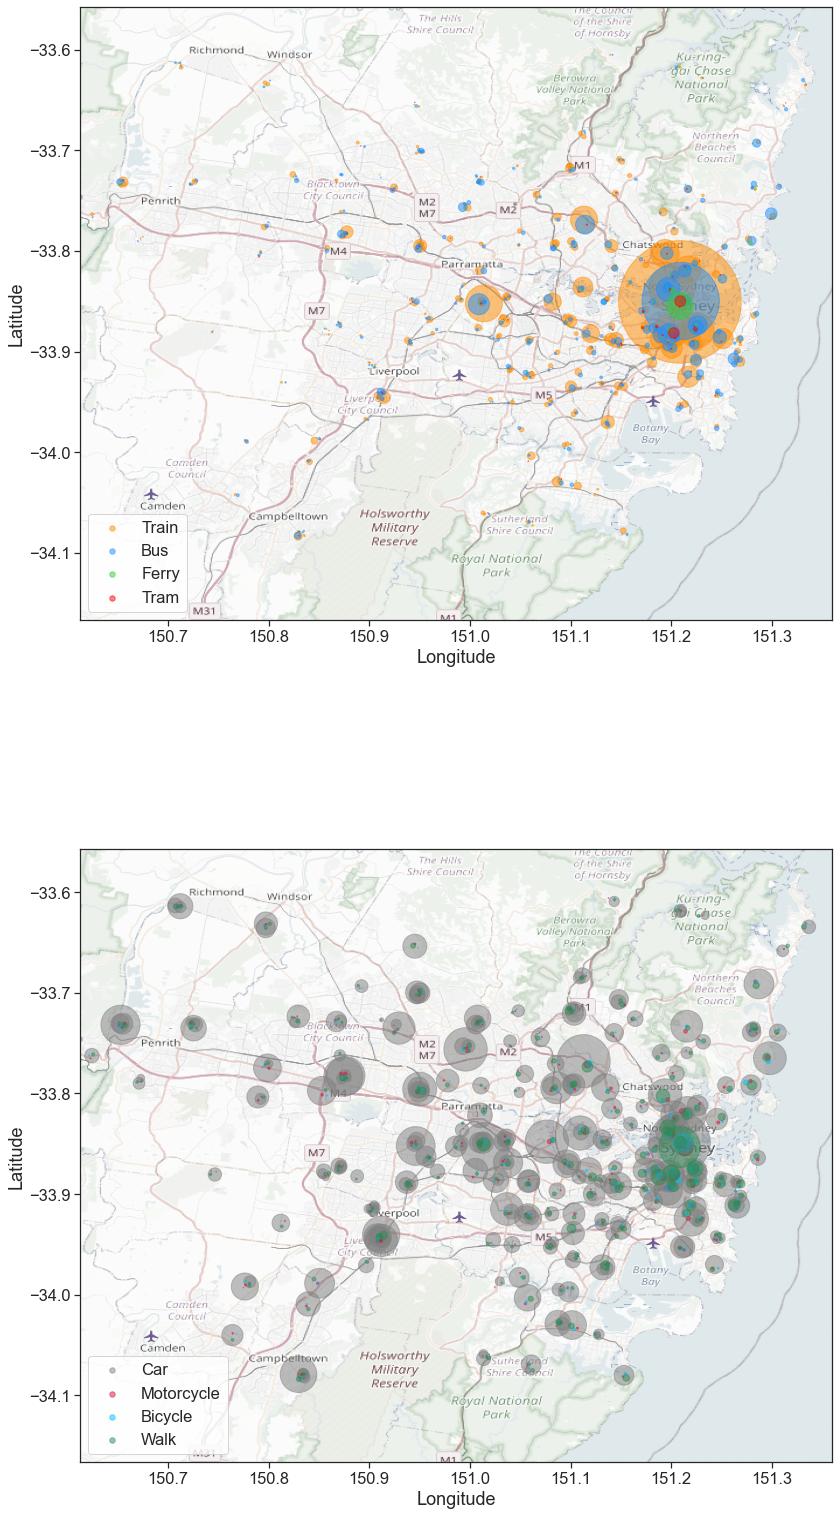

In [33]:
# load background map image with coordinate bounding box
syd_map=plt.imread('data/sydmap1.png')
BBox = ((150.6129, 151.3600,
         -34.16649, -33.5574))

# public modes of transport
mtws_pt_no = ['Train_no', 'Bus_no', 'Ferry_no', 'Tram_no']
colors_pt = ['darkorange','dodgerblue','limegreen','red']
fig, axes = plt.subplots(2,1,figsize = (12,24))
axes[0].set_xlim(BBox[0],BBox[1])
axes[0].set_ylim(BBox[2],BBox[3])
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].imshow(syd_map, zorder=0, extent = BBox, aspect='equal', alpha = .8)
for col, clr in zip(datapc[mtws_pt_no], colors_pt):
    jitter = 0.007*np.random.rand(len(datapc.lat))
    jitter2 = 0.007*np.random.rand(len(datapc.lat))
    axes[0].scatter(datapc.lon+jitter,datapc.lat+jitter2,s=datapc[col]/10, alpha = 0.5, color=clr)
lgnd = axes[0].legend(mtws)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

# private modes of transport
mtws_pvt_no = ['Car_no', 'Motorcycle_no', 'Bicycle_no', 'Walk_no' ]
colors_pvt = ['gray','crimson','deepskyblue','seagreen']
axes[1].set_xlim(BBox[0],BBox[1])
axes[1].set_ylim(BBox[2],BBox[3])
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].imshow(syd_map, zorder=0, extent = BBox, aspect='equal', alpha = .8)
for col, clr in zip(datapc[mtws_pvt_no], colors_pvt):
    jitter = 0.007*np.random.rand(len(datapc.lat))
    jitter2 = 0.007*np.random.rand(len(datapc.lat))
    axes[1].scatter(datapc.lon+jitter,datapc.lat+jitter2,s=datapc[col]/10, alpha = 0.5, color=clr)
lgnd = axes[1].legend(mtws[4:8])
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

plt.show()

##### Quick insights
- From the first figure we see that people living in areas far from the city prefer buses instead of trains, possibly due to the lack of close train lines.
- The most usage of public transports can be witnessed in the city as compared to other Sydney areas.
- From the second figure we see that the most common mode of private transport is car.
- People who prefer to walk are mostly in the city.
- The least used mode of private transport vehicle is motorcycle.


### 6.2 Distributions

#### 6.2.1 Distribution of Method of Commute

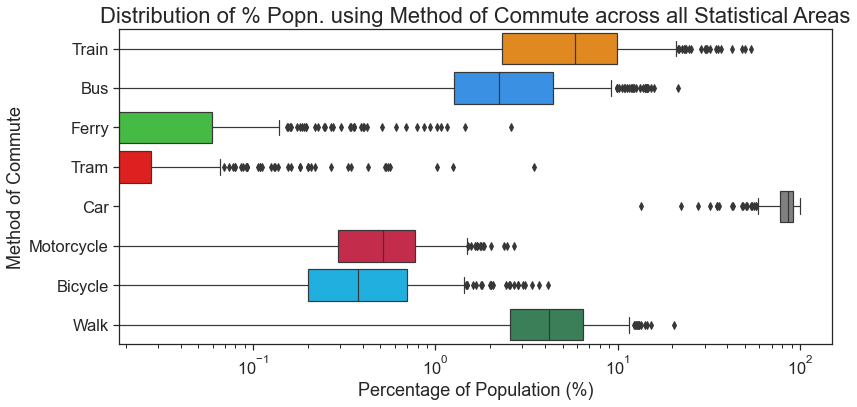

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

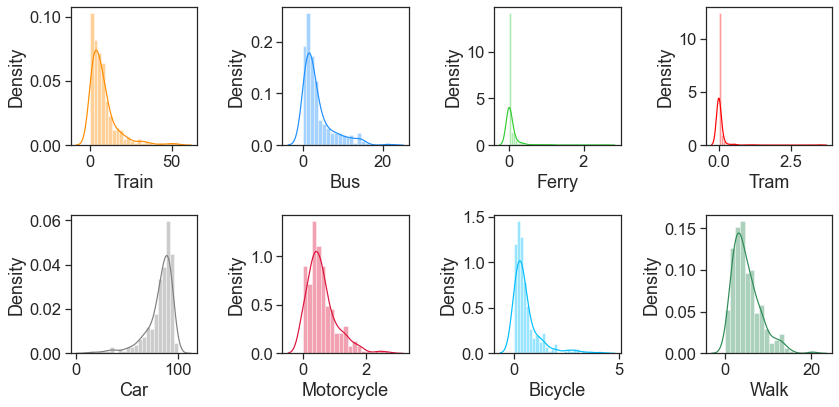

Train       Bus     Ferry       Tram       Car  Motorcycle  \
Skewness  2.486707  1.816706  5.971658  11.126798 -2.055185    1.378508   

           Bicycle      Walk  
Skewness  2.484071  1.223801

In [34]:
xxxx = mtws

f, ax = plt.subplots(figsize=(12,6))
colors = ['darkorange','dodgerblue','limegreen','red','gray','crimson','deepskyblue','seagreen']
plt.title('Distribution of % Popn. using Method of Commute across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Method of Commute')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xscale('log')
plt.show()

f, axes = plt.subplots(2,4, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- The median value of "car" exceeds all other mode of transports. Meaning, majority of the population use cars.
- Tram and ferry have the furthest outliers from median. Considering their first quartile couldn't fit in the graph, it is suffice to say that a niche amount of population uses these modes of transport.
- From the skewness, we can see our data is highly assymetrical. Tram being highluy positively skewed indicates a mean larger than the mode, whereas car being negatively skewed indicate most values are on the right side of the graph and the mean is lesser than the medina and mode.

#### 6.2.2 Distribution of Personal Characteristics

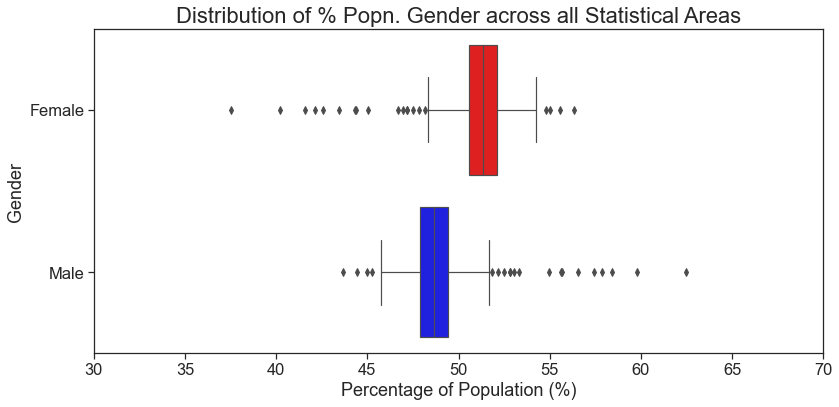

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


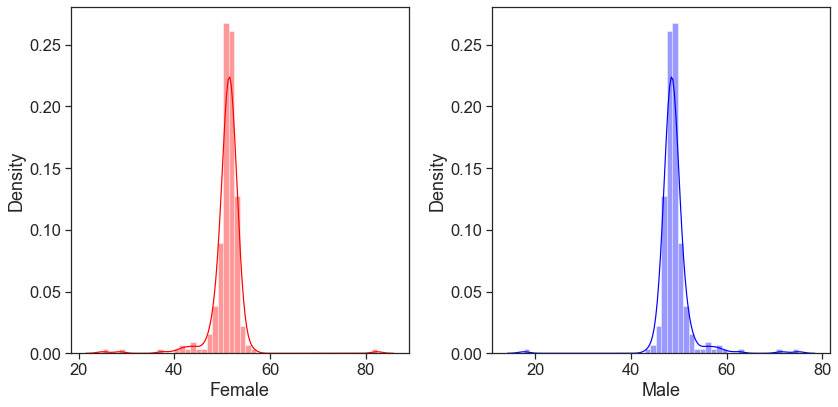

Female     Male
Skewness -0.38898  0.38898

In [35]:
xxxx = sexs

f, ax = plt.subplots(figsize=(12,6))
colors = ['red','blue']
plt.title('Distribution of % Popn. Gender across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Gender')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xlim(30,70)
plt.show()

f, axes = plt.subplots(1,2, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- Female population is slightly more than the male population, so there is not much difference between the two graphs.
- We can wonder whether this is because women work more than men or because the city has more female population overall. (The datasets provided can not give us a concrete evidence of either of these questions and they aren't relevant to the study, hence they have been dropped) 

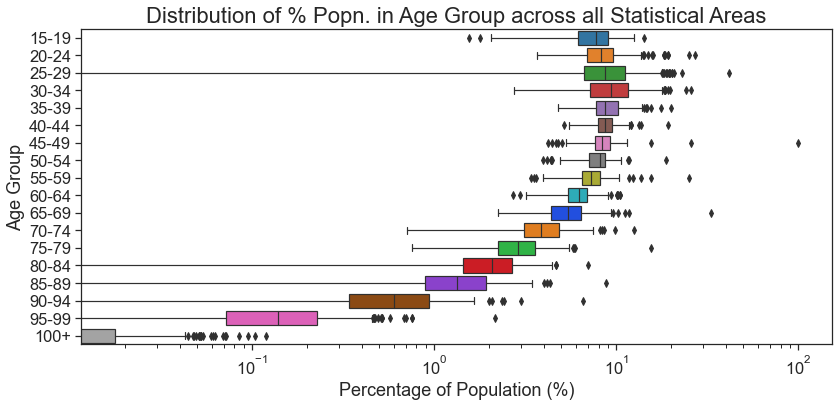

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

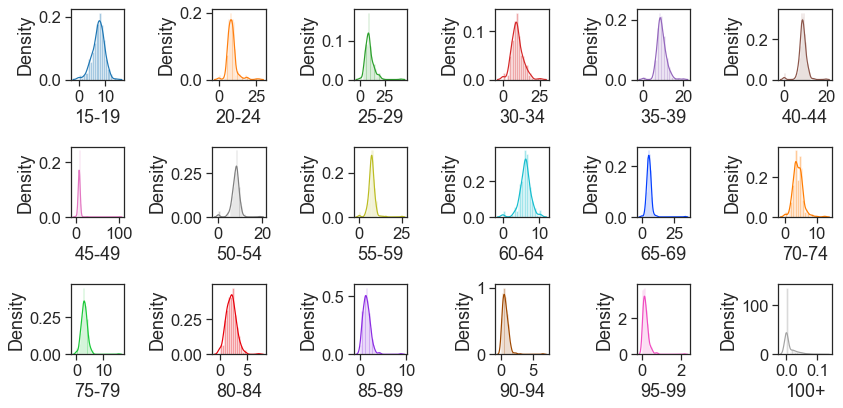

15-19     20-24     25-29     30-34    35-39     40-44     45-49  \
Skewness -0.507091  2.118313  2.038418  0.629667  0.52085 -0.655122  14.14959   

            50-54     55-59     60-64     65-69     70-74     75-79     80-84  \
Skewness -0.69903  2.300431 -0.663671  6.563892  0.897233  3.200817  0.589643   

             85-89     90-94     95-99      100+  
Skewness  2.565071  4.544479  5.411684  2.401789

In [36]:
xxxx = ages

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. in Age Group across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Age Group')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xscale('log')
plt.show()

f, axes = plt.subplots(3,6, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- From the graph we can see that most percentage of population is under age 65.
- The most symmetrical skewed graphs of ages are: 15-19, 35-39, and 80-84.
- Surprisingly, the most positively skewed graph is for ages 45-49.

#### 6.2.3 Distribution of Employment Characteristics

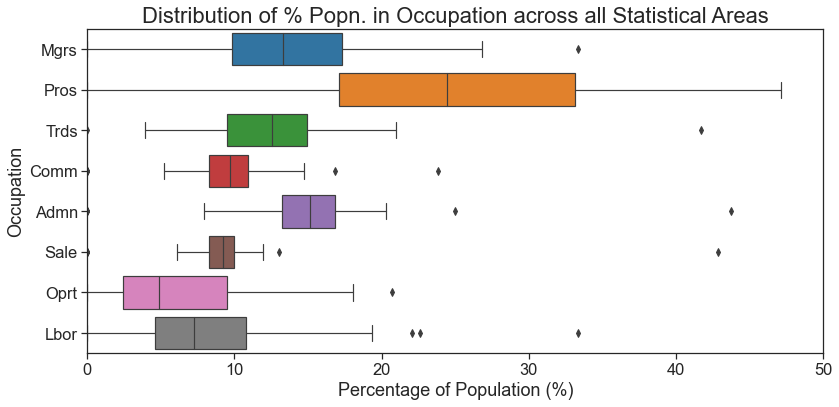

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

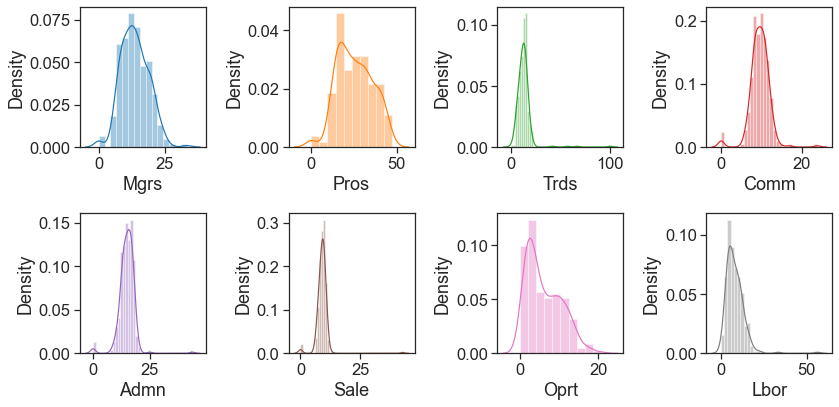

Mgrs      Pros      Trds      Comm      Admn      Sale  \
Skewness  0.231009  0.086024  6.655169 -0.203822  0.974463  6.758982   

              Oprt      Lbor  
Skewness  0.689896  3.338461

In [37]:
xxxx = occs

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. in Occupation across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Occupation')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xlim(0,50)
plt.show()

f, axes = plt.subplots(2,4, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- Professionals have the highest spread with no outliers, all othe occupations have outliers.
- The most symmetrically skewed occupations are Managers, Professionals, Community and Personal Service workers.

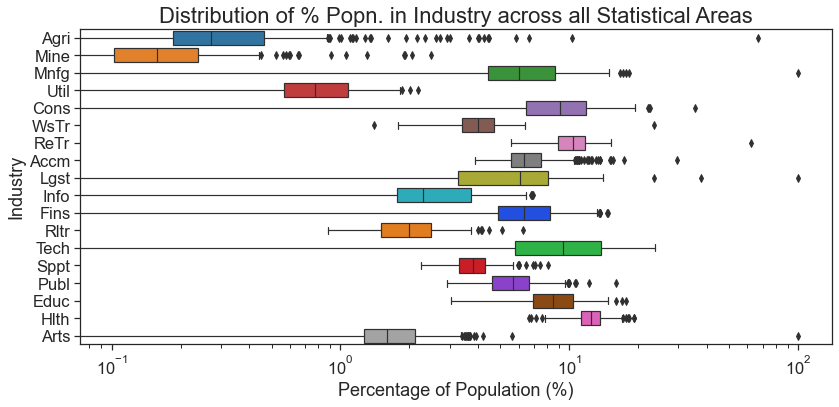

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

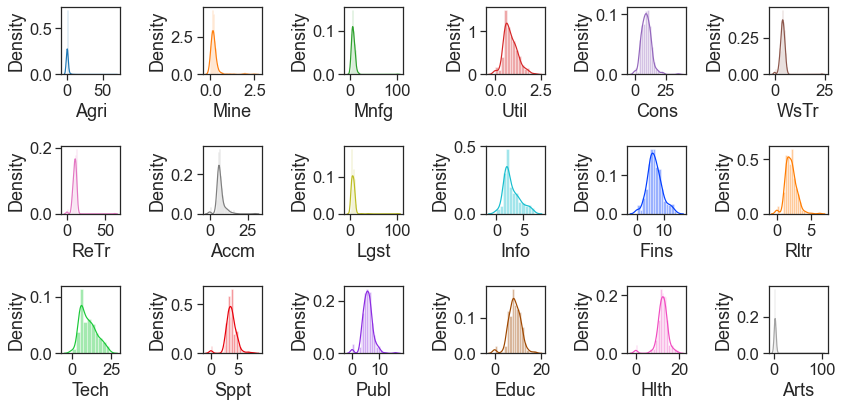

Agri      Mine       Mnfg      Util      Cons      WsTr  \
Skewness  15.084072  5.226512  11.077787  0.621383  1.249912  6.642575   

              ReTr     Accm       Lgst      Info      Fins     Rltr      Tech  \
Skewness  8.373505  2.69021  10.647199  0.841038  0.394918  0.80231  0.572256   

              Sppt      Publ      Educ      Hlth       Arts  
Skewness -0.236633  0.474798 -0.210961 -1.796526  16.152586

In [38]:
xxxx = inds

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. in Industry across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Industry')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xscale('log')
plt.show()

f, axes = plt.subplots(3,6, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- In the graph, only technology have no outliers.
- Agriculture and arts have very positively skewed graphs.

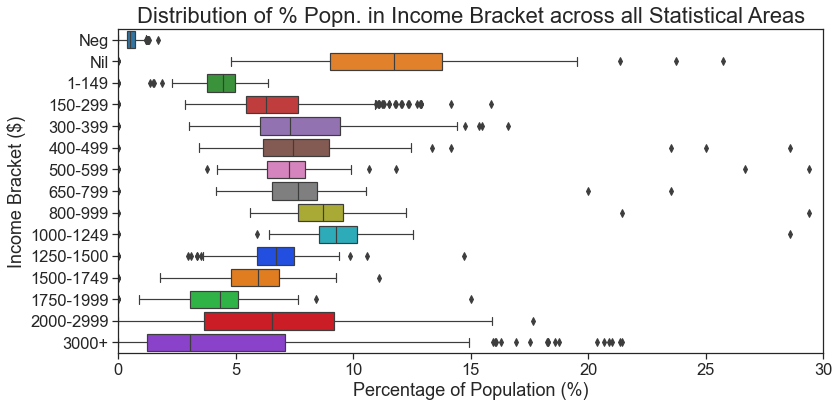

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

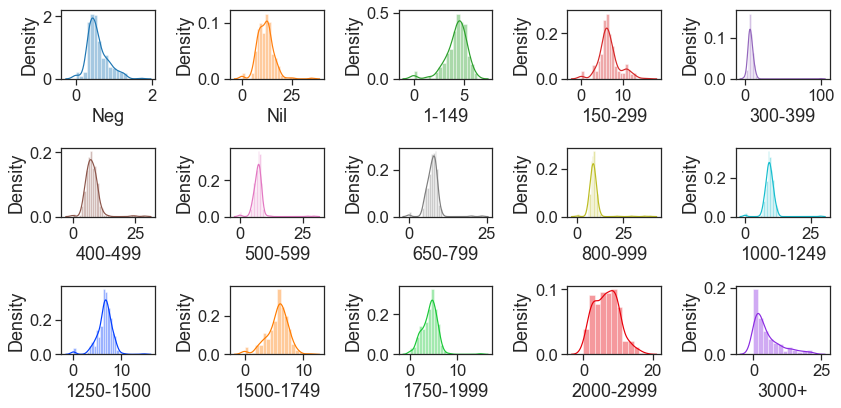

Neg       Nil     1-149   150-299    300-399   400-499  \
Skewness  0.949615  0.797213 -1.420781  0.527533  11.870261  3.006189   

          500-599   650-799  800-999  1000-1249  1250-1500  1500-1749  \
Skewness   5.0231  2.185259  6.12896   2.350572  -0.760481  -0.723052   

          1750-1999  2000-2999     3000+  
Skewness   0.654096   0.300487  1.451283

In [39]:
xxxx = incs

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. in Income Bracket across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Income Bracket ($)')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xlim(0,30)
plt.show()

f, axes = plt.subplots(3,5, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- Majority of the graphs are left skewed.
- Symmetrically skewed graphs include 150-299, and 2000-2999.

#### 6.2.4 Distribution of Geographic Characteristics

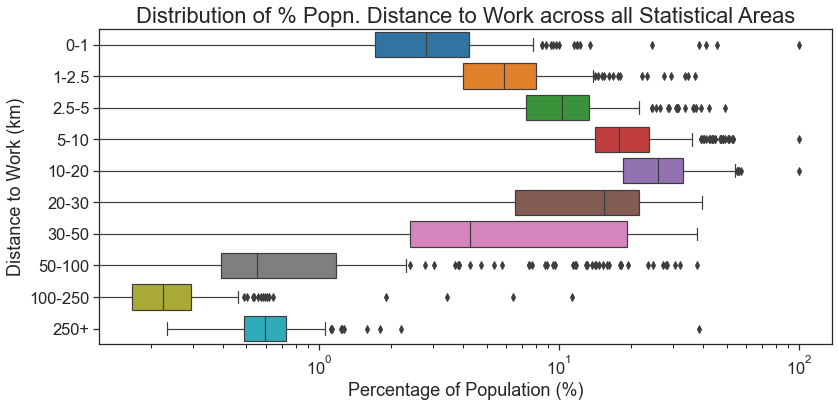

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

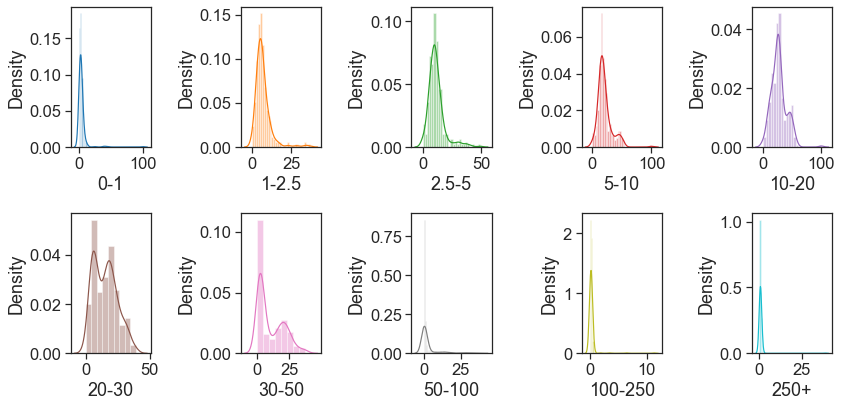

0-1     1-2.5    2.5-5      5-10     10-20     20-30     30-50  \
Skewness  9.147898  2.993729  2.06651  1.920501  0.896055  0.418478  0.816659   

            50-100   100-250     250+  
Skewness  3.386835  11.35465  16.2604

In [40]:
xxxx = dtws

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. Distance to Work across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Distance to Work (km)')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xscale('log')
plt.show()

f, axes = plt.subplots(2,5, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- From the graph we can see that most population have 10-20 km distance to work.
- Distances larger or smaller than 10-20 km tend to have a smaller population percentage.
- Several outliers exist on all distances.
- The only symmetric skewness we can see is in the 20-30km distance.
- Very highly skewed graphs (positive) can be seen in 0-1, 100-250, and 250+.

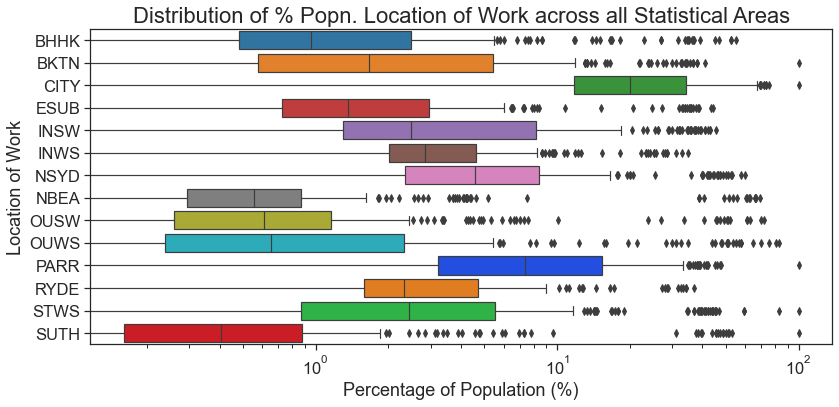

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

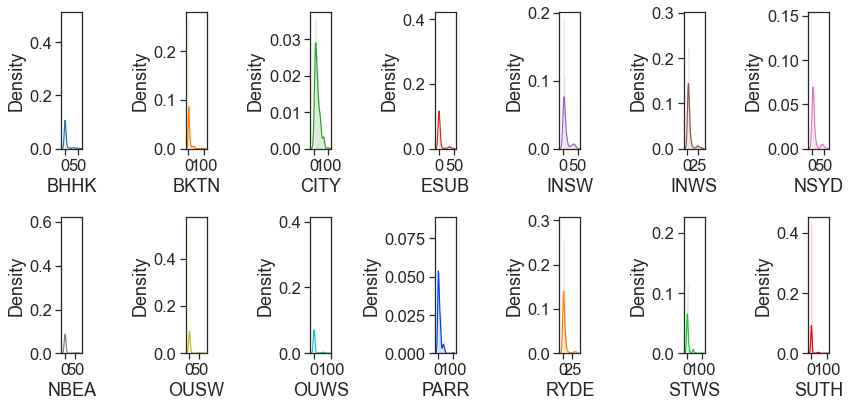

BHHK      BKTN     CITY     ESUB      INSW      INWS    NSYD  \
Skewness  3.526134  4.257865  1.21195  3.30247  2.066811  3.115723  2.6272   

              NBEA      OUSW      OUWS      PARR      RYDE      STWS      SUTH  
Skewness  4.098929  4.133894  3.330883  2.640181  3.661148  3.002868  4.360516

In [41]:
xxxx = pows

f, ax = plt.subplots(figsize=(12,6))
colors = sns.color_palette('tab10')+sns.color_palette('bright')
plt.title('Distribution of % Popn. Location of Work across all Statistical Areas', fontsize=22)
sns.boxplot(data=datapc[xxxx],palette = sns.color_palette(colors), orient='h')
ax.set_ylabel('Location of Work')
ax.set_xlabel('Percentage of Population (%)')
ax.set_xscale('log')
plt.show()

f, axes = plt.subplots(2,7, figsize=(12,6))
for ax, col, clr in zip(axes.flat, datapc[xxxx], colors):
    sns.distplot(datapc[col], color=clr, ax=ax)
plt.show()

display(pd.DataFrame(datapc[xxxx].skew(),columns=['Skewness']).transpose())

##### Quick insights
- We can see from the graph above that most of the population work in the city area.
- Graphs are all hihgly positively skewed with no symmetric skewes in sight.

### 6.3 Correlations

#### 6.3.1 Overall Correlations between All Features

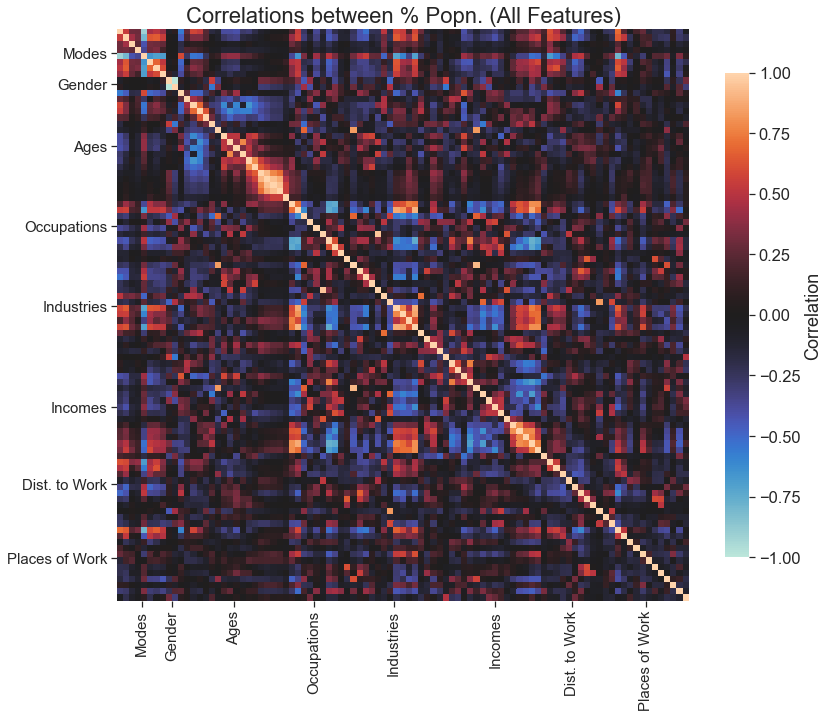

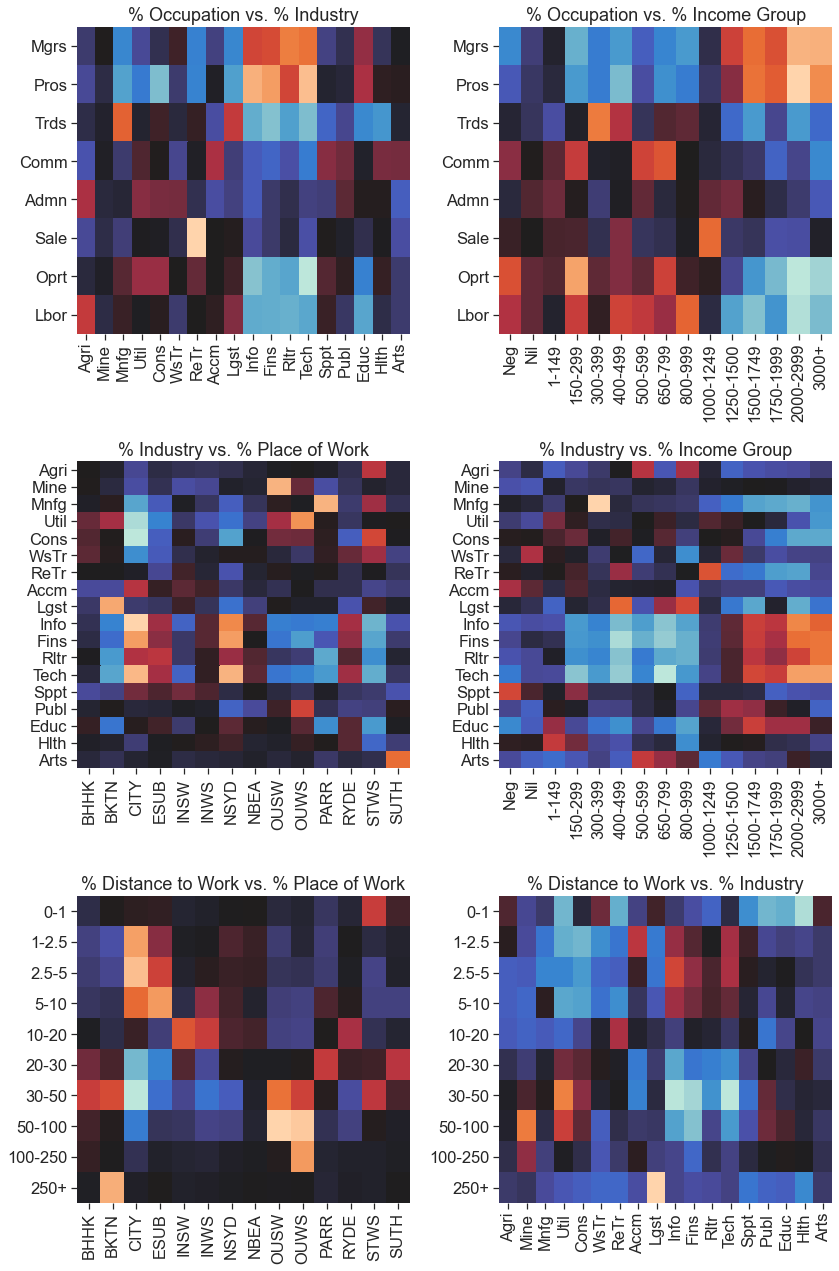

In [42]:
# overall correlation heatmap
corr1 = round((datapc[mtws+sexs+ages+occs+inds+incs+dtws+pows].corr()),2)
corr2 = round((datapc[occs+inds].corr()),2)

f = plt.figure(figsize=(12,12))
sns.heatmap(corr1, square=True, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between % Popn. (All Features)', fontsize=22)
a=len(mtws)/2  # categorical tick labelling
b=len(mtws)+len(sexs)/2
c=len(mtws)+len(sexs)+len(ages)/2
d=len(mtws)+len(sexs)+len(ages)+len(occs)/2
e=len(mtws)+len(sexs)+len(ages)+len(occs)+len(inds)/2
f=len(mtws)+len(sexs)+len(ages)+len(occs)+len(inds)+len(incs)/2
g=len(mtws)+len(sexs)+len(ages)+len(occs)+len(inds)+len(incs)+len(dtws)/2
h=len(mtws)+len(sexs)+len(ages)+len(occs)+len(inds)+len(incs)+len(dtws)+len(pows)/2
catticks = (a,b,c,d,e,f,g,h)
catlabels = ('Modes','Gender','Ages','Occupations','Industries','Incomes','Dist. to Work','Places of Work')
plt.yticks(catticks, catlabels, rotation='0',fontsize=15)
plt.xticks(catticks, catlabels, rotation='90',fontsize=15)
plt.grid(True, axis='both', which='minor',color='r')

# areas of interest
corr2 = corr2.drop(columns=corr2[occs]).head(len(occs))
corr3 = round((datapc[occs+incs].corr()),2)
corr3 = corr3.drop(columns=corr3[occs]).head(len(occs))
corr4 = round((datapc[inds+pows].corr()),2)
corr4 = corr4.drop(columns=corr4[inds]).head(len(inds))
corr5 = round((datapc[inds+incs].corr()),2)
corr5 = corr5.drop(columns=corr5[inds]).head(len(inds))
corr6 = round((datapc[dtws+pows].corr()),2)
corr6 = corr6.drop(columns=corr6[dtws]).head(len(dtws))
corr7 = round((datapc[dtws+inds].corr()),2)
corr7 = corr7.drop(columns=corr7[dtws]).head(len(dtws))

# areas of interest heatmaps
fig, axes = plt.subplots(3,2, figsize = (12,18))
sns.heatmap(corr2, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[0,0])
axes[0,0].set_title('% Occupation vs. % Industry')
sns.heatmap(corr3, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[0,1])
axes[0,1].set_title('% Occupation vs. % Income Group')
sns.heatmap(corr4, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[1,0])
axes[1,0].set_title('% Industry vs. % Place of Work')
sns.heatmap(corr5, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[1,1])
axes[1,1].set_title('% Industry vs. % Income Group')
sns.heatmap(corr6, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[2,0])
axes[2,0].set_title('% Distance to Work vs. % Place of Work')
sns.heatmap(corr7, cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire', xticklabels=True, yticklabels=True, cbar=False, ax=axes[2,1])
axes[2,1].set_title('% Distance to Work vs. % Industry')
plt.show()

##### Quick insights
- Most managers are paid well (in the higher bracket income).
- Area where most people work, being the city or North Sydney, have industry that are 'Information Media and Telecommunications', 'Financial and Insurance Services', 'Rental, Hiring and Real Estate Services', 'Professional, Scientific and Technical Services'. These are also the industries that get paid more on the higher bracket.
- Most people who work in the city or north sydney have a low distance to work (being 1-5km).

#### 6.3.2 Correlations between Commuting Method and Personal Characteristics

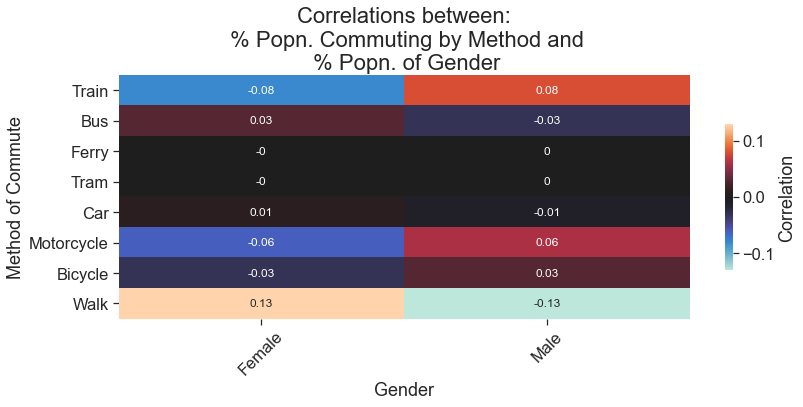

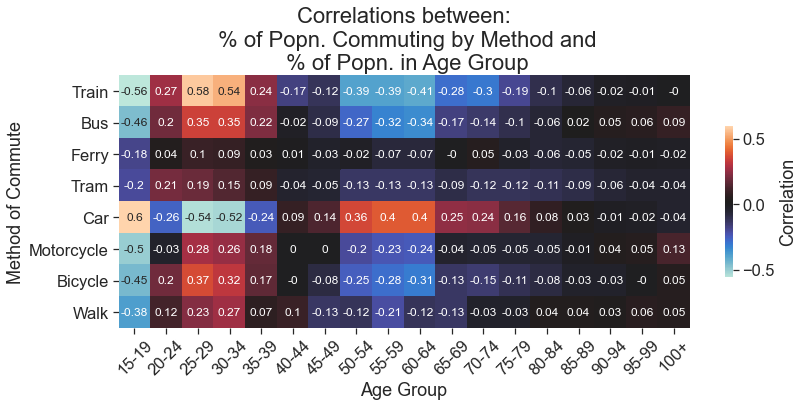

In [43]:
# heatmaps showing correlations between commuting method proportions and employment characteristic proportions

corr1 = round((datapc[mtws+sexs].corr()),2)
corr1 = corr1.drop(columns=corr1[mtws]).head(8)

corr2 = round((datapc[mtws+ages].corr()),2)
corr2 = corr2.drop(columns=corr2[mtws]).head(8)

f = plt.figure(figsize=(12,6))
sns.heatmap(corr1, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. of Gender', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Gender')
plt.yticks(rotation='0')
plt.xticks(rotation='45')
f = plt.figure(figsize=(12,6))
sns.heatmap(corr2, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % of Popn. Commuting by Method and\n % of Popn. in Age Group', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Age Group')
plt.yticks(rotation='0')
plt.xticks(rotation='45')

plt.show()

##### Quick insights
- High positive correlation between people in ages 50-64 and using car as their mode of transport.
- We can also see a high negative correlation between people in ages 25-34 and using car as their mode of transport.
- Almost no effect when we take gender into account.

#### 6.3.3 Correlations between Commuting Method and Employment Characteristics

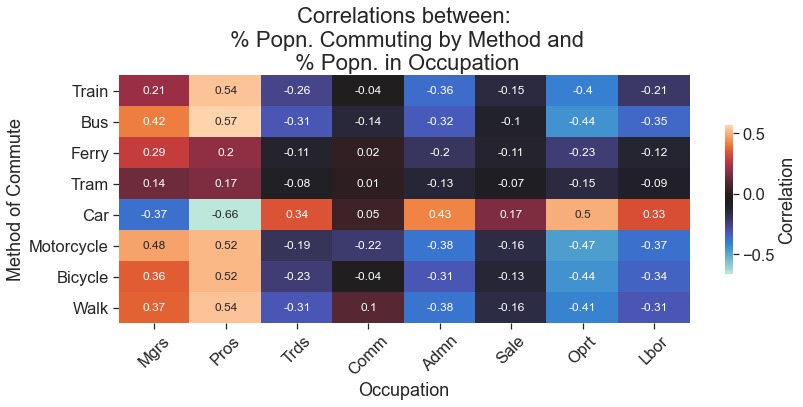

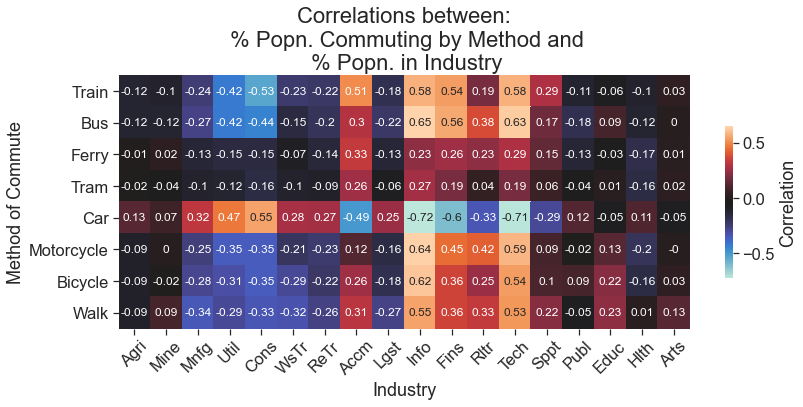

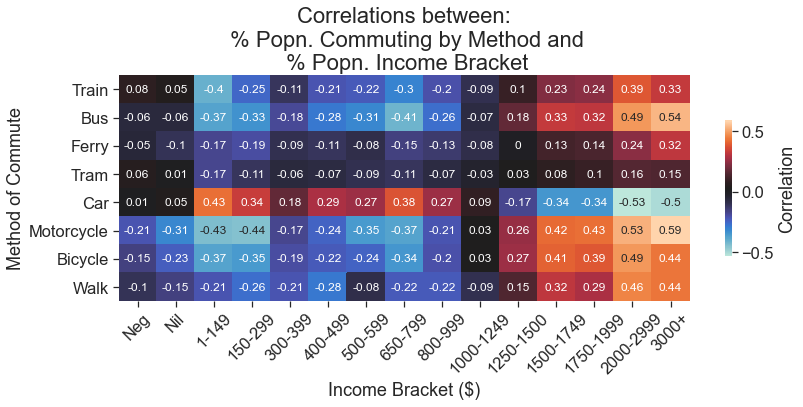

In [46]:
# heatmaps showing correlations between commuting method proportions and employment characteristic proportions

corr1 = round((datapc[mtws+incs].corr()),2)
corr1 = corr1.drop(columns=corr1[mtws]).head(8)

corr2 = round((datapc[mtws+inds].corr()),2)
corr2 = corr2.drop(columns=corr2[mtws]).head(8)

corr3 = round((datapc[mtws+occs].corr()),2)
corr3 = corr3.drop(columns=corr3[mtws]).head(8)

f = plt.figure(figsize=(12,6))
sns.heatmap(corr3, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. in Occupation', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Occupation')
plt.yticks(rotation='0')
plt.xticks(rotation='45')

f = plt.figure(figsize=(12,6))
sns.heatmap(corr2, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. in Industry', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Industry')
plt.yticks(rotation='0')
plt.xticks(rotation='45')

f = plt.figure(figsize=(12,6))
sns.heatmap(corr1, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. Income Bracket', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Income Bracket ($)')
plt.yticks(rotation='0')
plt.xticks(rotation='45')
plt.show()

##### Quick insights
- Areas with high population of technicians and service workers have higher car usage, because they will have to go to various places per day, so car will be a more flexible and convenience choice. Professional and managers are most likely to use the public transport, because most of them are working in urban area, which in these area public transport is well developed.

#### 6.3.4 Correlations between Commuting Method and Geographic Characteristics

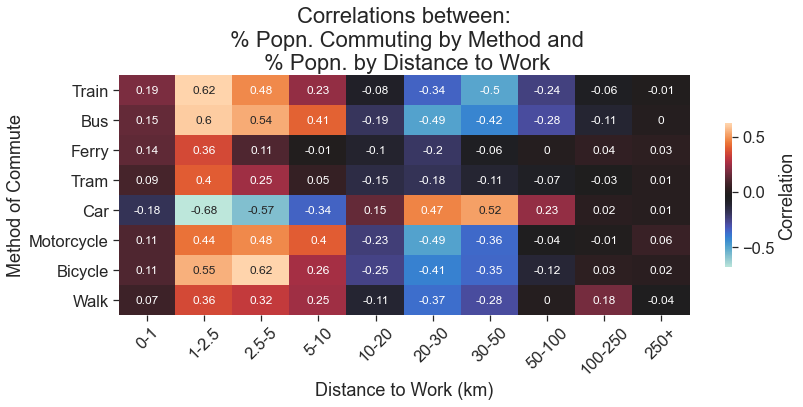

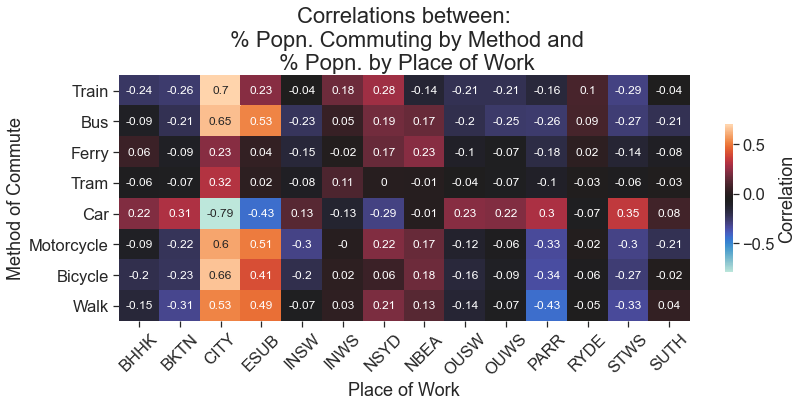

In [36]:
# heatmaps showing correlations between commuting method proportions and employment characteristic proportions

corr1 = round((datapc[mtws+dtws].corr()),2)
corr1 = corr1.drop(columns=corr1[mtws]).head(8)

corr2 = round((datapc[mtws+pows].corr()),2)
corr2 = corr2.drop(columns=corr2[mtws]).head(8)

f = plt.figure(figsize=(12,6))
sns.heatmap(corr1, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. by Distance to Work', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Distance to Work (km)')
plt.yticks(rotation='0')
plt.xticks(rotation='45')

f = plt.figure(figsize=(12,6))
sns.heatmap(corr2, annot=True, annot_kws=dict(size=12), cbar_kws=dict(shrink=.6, label='Correlation'), cmap='icefire')
plt.title('Correlations between:\n % Popn. Commuting by Method and\n % Popn. by Place of Work', fontsize=22)
plt.ylabel('Method of Commute')
plt.xlabel('Place of Work')
plt.yticks(rotation='0')
plt.xticks(rotation='45')

plt.show()

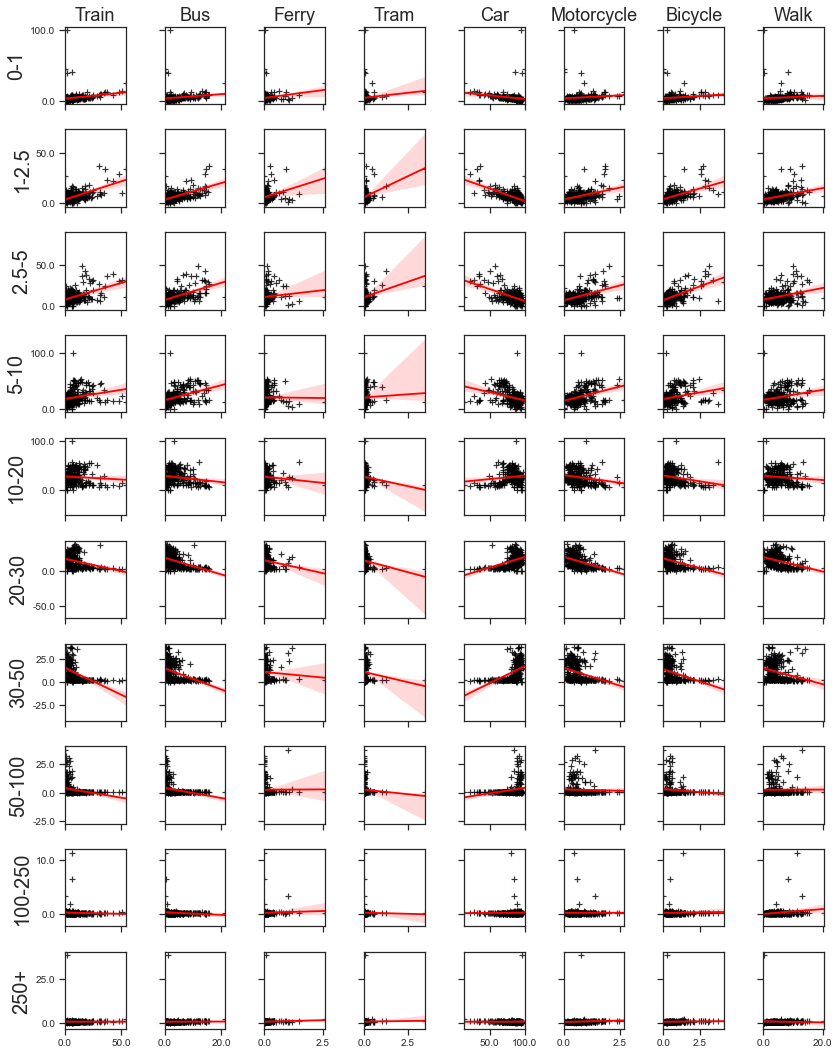

In [37]:
regplots(mtws,dtws)

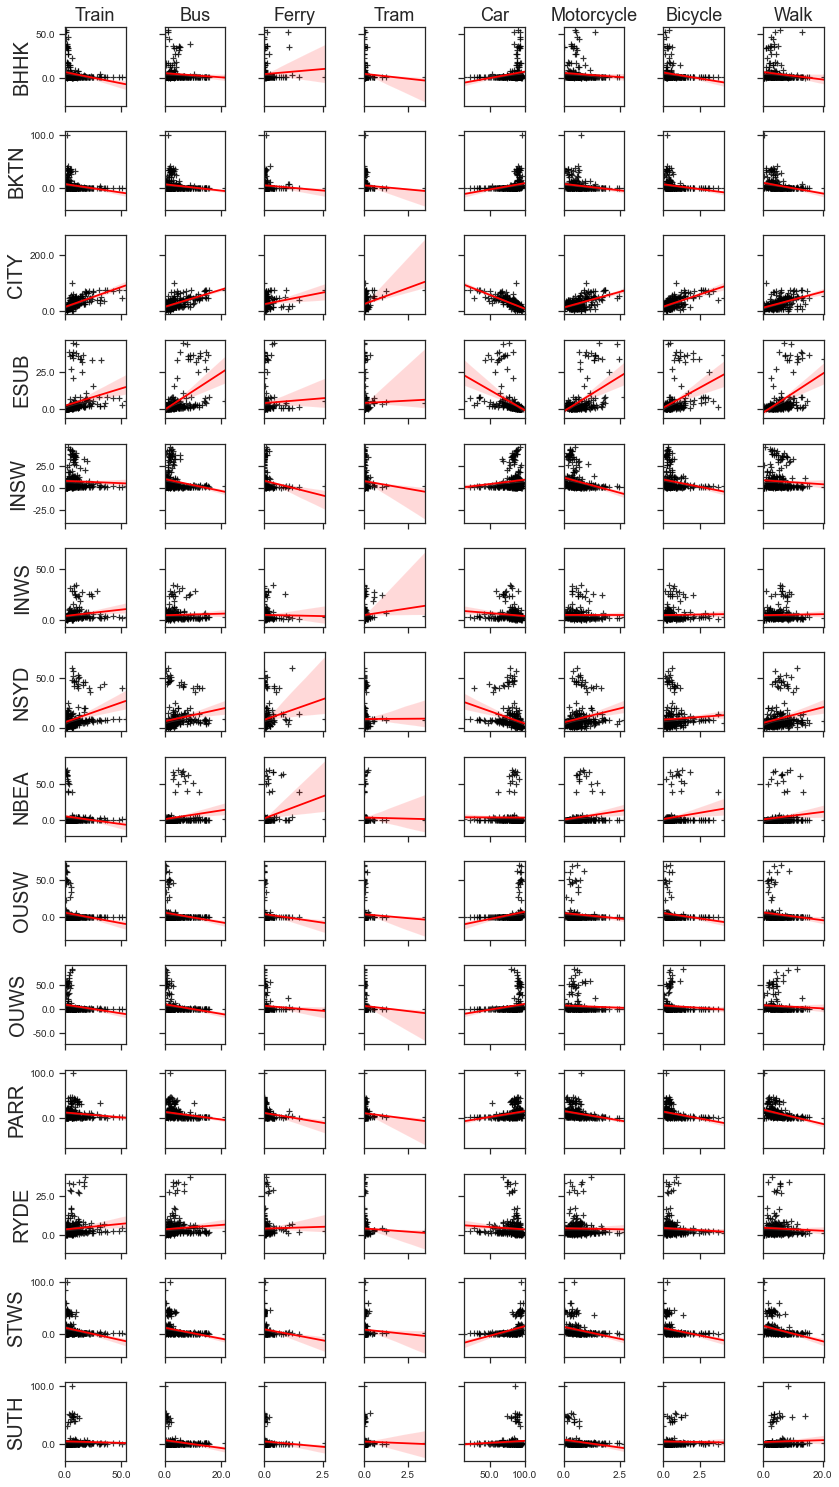

In [38]:
regplots(mtws,pows)

##### Quick insights
- People work in urban area will intend to take public transport, and people work in suburban area will driving car to work, this might because there are more choice of public transportation in urban area, and there will be less choices of public transport in suburban area, so in suburban area there is a higher usage of car.

***
## 7. Modelling

### 7.1 Preparing Training and Testing Data Sets

The combined dataset prepared earlier is split into 80:20 training and testing sets for model evaluation.

In [53]:
train, test = train_test_split(datapc, test_size=0.2, random_state=17)
display(train.shape)
display(test.shape)

(219, 105)

(55, 105)

In [54]:
# set features to use
features = sexs+ages+occs+inds+incs+dtws+pows
targets = mtws

# remove non-relevant features from datasets
X_train = train[features]
Y_train = train[mtws]
X_test = test[features]
Y_test = test[mtws]

print('Size - Training Set:')
print(' X_train:', X_train.shape)
print(' Y_train:', Y_train.shape)
print('\nFeatures - Training Set:\n', X_train.shape[1], ':',X_train.columns.tolist())

print('\nSize - Testing Set:')
print(' X_test:', X_test.shape)
print(' Y_test:', Y_test.shape)
print('\nFeatures - Testing Set:\n', X_test.shape[1], ':',X_test.columns.tolist())

Size - Training Set:
 X_train: (219, 85)
 Y_train: (219, 8)

Features - Training Set:
 85 : ['Female', 'Male', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+', 'Mgrs', 'Pros', 'Trds', 'Comm', 'Admn', 'Sale', 'Oprt', 'Lbor', 'Agri', 'Mine', 'Mnfg', 'Util', 'Cons', 'WsTr', 'ReTr', 'Accm', 'Lgst', 'Info', 'Fins', 'Rltr', 'Tech', 'Sppt', 'Publ', 'Educ', 'Hlth', 'Arts', 'Neg', 'Nil', '1-149', '150-299', '300-399', '400-499', '500-599', '650-799', '800-999', '1000-1249', '1250-1500', '1500-1749', '1750-1999', '2000-2999', '3000+', '0-1', '1-2.5', '2.5-5', '5-10', '10-20', '20-30', '30-50', '50-100', '100-250', '250+', 'BHHK', 'BKTN', 'CITY', 'ESUB', 'INSW', 'INWS', 'NSYD', 'NBEA', 'OUSW', 'OUWS', 'PARR', 'RYDE', 'STWS', 'SUTH']

Size - Testing Set:
 X_test: (55, 85)
 Y_test: (55, 8)

Features - Testing Set:
 85 : ['Female', 'Male', '15-19', '20-24', '25-29', '30-34', '35-39', '40-4

### 7.2 Baseline Performances

Baseline performances are established for four regression models inherently capable of handling multiple target outputs. All 85 features and 8 targets are trained using Linear, Random Forest, Decision Tree and KNeighbors regressors from the sklearn library.

#### 7.2.1 Linear Regression

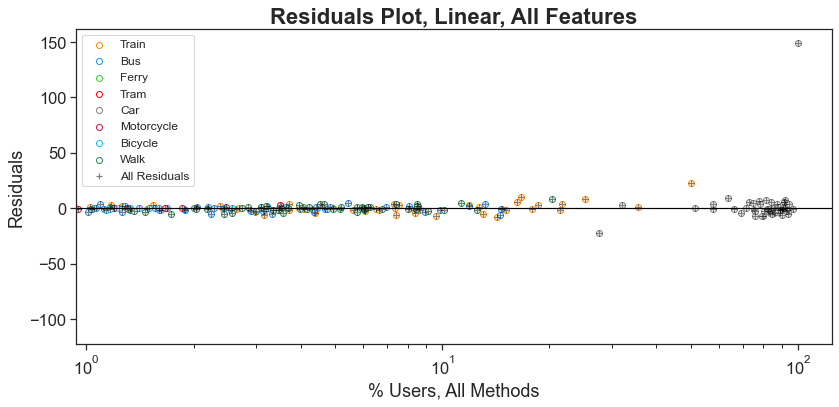

#### Linear Model Performance


 **Training Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   2.80  1.36   0.14  0.09  3.06        0.19     0.25  1.46   
R2     0.89  0.86   0.70  0.53  0.95        0.83     0.86  0.79   
MAE    2.12  1.01   0.09  0.06  2.24        0.15     0.19  1.14   

      Uniform Average  
RMSE             1.63  
R2               0.80  
MAE              0.88


 **Testing Set Scores**

Train   Bus  Ferry  Tram    Car  Motorcycle  Bicycle  Walk  \
RMSE  15.47  3.72   0.24  0.45  20.70        0.59     0.40  8.22   
R2    -1.91 -0.10  -0.24  0.08  -1.12       -0.46     0.56 -4.73   
MAE    4.85  2.04   0.16  0.16   6.17        0.30     0.30  2.88   

      Uniform Average  
RMSE             9.68  
R2              -0.99  
MAE              2.11

In [55]:
regLR = LinearRegression()
regLR.fit(X_train, Y_train)

# predicting and evaluating model performance using standard regression metrics
Y_train_LR = regLR.predict(X_train)
Y_test_LR = regLR.predict(X_test)

colors = ['darkorange','dodgerblue','limegreen','red','gray','crimson','deepskyblue','seagreen']

#residual plot
plt.figure(figsize=(12,6))
for i,mtw,col in zip(range(0,len(mtws)),mtws,colors):
    residual=Y_test.values[:,i]-Y_test_LR[:,i]
    plt.scatter(Y_test.iloc[:,i], residual, color='white', edgecolor=col)
allresidualsLR=Y_test.values-Y_test_LR
plt.scatter(Y_test, allresidualsLR, color='black', marker='+', edgecolor='black', alpha=0.5)
plt.legend(mtws+['All Residuals'], loc='best', fontsize=12)
plt.title('Residuals Plot, Linear, All Features', fontsize=22, fontweight='bold')
plt.xlabel('% Users, All Methods')
plt.ylabel('Residuals')
plt.xscale('log')
plt.axhline(0, color='black')
plt.show()

printmd('#### Linear Model Performance')
printmd('\n **Training Set Scores**')
scores_LR_train=scores(Y_train_LR,Y_train,mtws)

printmd('\n **Testing Set Scores**')
scores_LR_test=scores(Y_test_LR,Y_test,mtws)

#### 7.2.2 Random Forest Regression

Random state is fixed to 17 for repeatability. An arbitrary baseline of 64 trees is used.

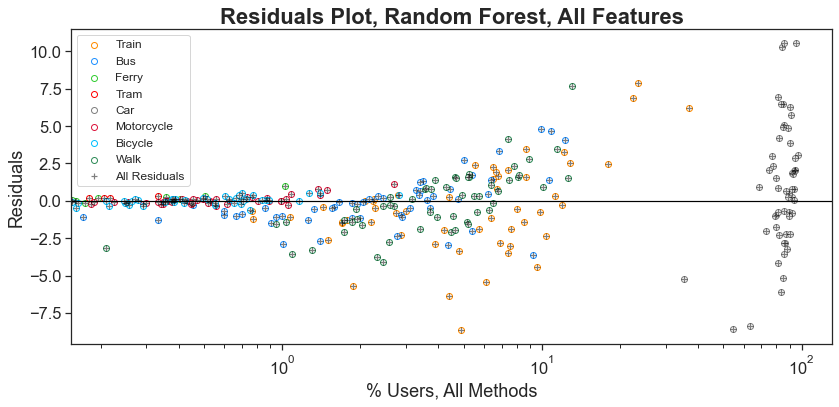

#### Random Forest Model Performance


 **Training Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   2.08  0.80   0.08  0.09  2.60        0.11     0.16  0.91   
R2     0.95  0.96   0.91  0.89  0.97        0.94     0.95  0.93   
MAE    1.16  0.54   0.04  0.03  1.51        0.08     0.11  0.66   

      Uniform Average  
RMSE             1.25  
R2               0.94  
MAE              0.52


 **Testing Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   3.05  1.82   0.16  0.11  4.30        0.31     0.28  2.10   
R2     0.77  0.61   0.07 -1.76  0.83        0.57     0.64  0.47   
MAE    2.30  1.33   0.08  0.06  3.32        0.21     0.22  1.63   

      Uniform Average  
RMSE             2.11  
R2               0.27  
MAE              1.14

In [68]:
regRF = RandomForestRegressor(n_estimators=64, random_state=17)
regRF.fit(X_train, Y_train)
# predicting and evaluating model performance using standard regression metrics
Y_train_RF = regRF.predict(X_train)
Y_test_RF = regRF.predict(X_test)

colors = ['darkorange','dodgerblue','limegreen','red','gray','crimson','deepskyblue','seagreen']

#residual plot
plt.figure(figsize=(12,6))
for i,mtw,col in zip(range(0,len(mtws)),mtws,colors):
    residual=Y_test.values[:,i]-Y_test_RF[:,i]
    plt.scatter(Y_test.iloc[:,i], residual, color='white', edgecolor=col)
allresidualsRF=Y_test.values-Y_test_RF
plt.scatter(Y_test, allresidualsRF, color='black', marker='+', edgecolor='black', alpha=0.5)
plt.legend(mtws+['All Residuals'], loc='best', fontsize=12)
plt.title('Residuals Plot, Random Forest, All Features', fontsize=22, fontweight='bold')
plt.xlabel('% Users, All Methods')
plt.ylabel('Residuals')
plt.xscale('log')
plt.axhline(0, color='black')
plt.show()

printmd('#### Random Forest Model Performance')
printmd('\n **Training Set Scores**')
scores_RF_train=scores(Y_train_RF,Y_train,mtws)

printmd('\n **Testing Set Scores**')
scores_RF_test=scores(Y_test_RF,Y_test,mtws)

#### 7.2.3 Decision Tree Regression

Random state is fixed to 17 for repeatability. An arbitrary maximum depth of 8 is used.

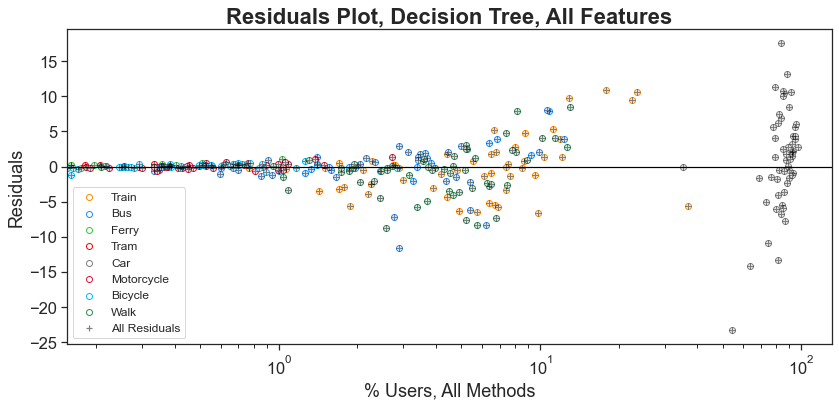

#### Decision Tree Model Performance


 **Training Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   0.75  0.72   0.07  0.04  0.76        0.20     0.20  0.74   
R2     0.99  0.96   0.92  0.98  1.00        0.82     0.92  0.95   
MAE    0.43  0.43   0.03  0.02  0.45        0.12     0.11  0.46   

      Uniform Average  
RMSE             0.54  
R2               0.94  
MAE              0.26


 **Testing Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   4.13  3.14   0.19  0.07  7.14        0.40     0.33  3.51   
R2     0.59 -0.17  -0.24 -0.02  0.52        0.27     0.47 -0.49   
MAE    3.04  1.98   0.09  0.03  5.31        0.31     0.25  2.53   

      Uniform Average  
RMSE             3.36  
R2               0.12  
MAE              1.69

In [69]:
regDT = DecisionTreeRegressor(max_depth=8, random_state=17)
regDT.fit(X_train, Y_train)
# predicting and evaluating model performance using standard regression metrics
Y_train_DT = regDT.predict(X_train)
Y_test_DT = regDT.predict(X_test)

colors = ['darkorange','dodgerblue','limegreen','red','gray','crimson','deepskyblue','seagreen']

#residual plot
plt.figure(figsize=(12,6))
for i,mtw,col in zip(range(0,len(mtws)),mtws,colors):
    residual=Y_test.values[:,i]-Y_test_DT[:,i]
    plt.scatter(Y_test.iloc[:,i], residual, color='white', edgecolor=col)
allresidualsDT=Y_test.values-Y_test_DT
plt.scatter(Y_test, allresidualsDT, color='black', marker='+', edgecolor='black', alpha=0.5)
plt.legend(mtws+['All Residuals'], loc='best', fontsize=12)
plt.title('Residuals Plot, Decision Tree, All Features', fontsize=22, fontweight='bold')
plt.xlabel('% Users, All Methods')
plt.ylabel('Residuals')
plt.xscale('log')
plt.axhline(0, color='black')
plt.show()

printmd('#### Decision Tree Model Performance')
printmd('\n **Training Set Scores**')
scores_DT_train=scores(Y_train_DT,Y_train,mtws)

printmd('\n **Testing Set Scores**')
scores_DT_test=scores(Y_test_DT,Y_test,mtws)

#### 7.2.4 KNeighbors Regression

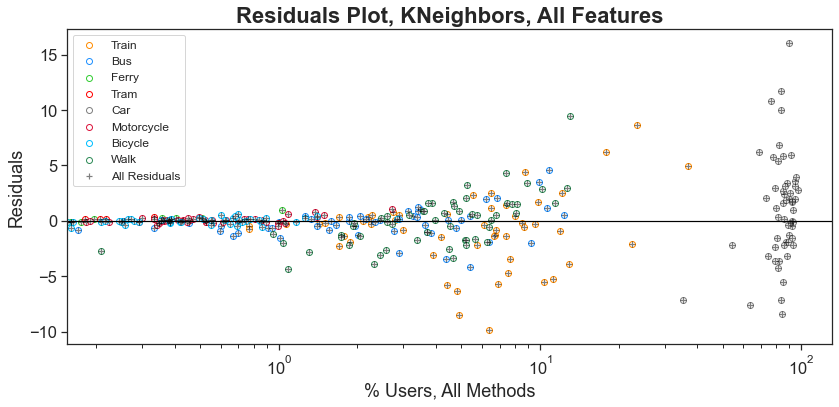

#### KNeighbor Model Performance


 **Training Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   4.05  1.69   0.19  0.22  5.16        0.25     0.36  1.92   
R2     0.79  0.80   0.46  0.36  0.87        0.71     0.74  0.66   
MAE    2.40  1.17   0.07  0.06  3.29        0.20     0.22  1.40   

      Uniform Average  
RMSE             2.50  
R2               0.68  
MAE              1.10


 **Testing Set Scores**

Train   Bus  Ferry  Tram   Car  Motorcycle  Bicycle  Walk  \
RMSE   3.33  1.42   0.17  0.12  4.88        0.28     0.28  2.32   
R2     0.73  0.76   0.00 -2.45  0.78        0.65     0.62  0.35   
MAE    2.29  0.98   0.08  0.06  3.69        0.19     0.21  1.76   

      Uniform Average  
RMSE             2.31  
R2               0.18  
MAE              1.16

In [70]:
regKN = KNeighborsRegressor()
regKN.fit(X_train, Y_train)
# predicting and evaluating model performance using standard regression metrics
Y_train_KN = regKN.predict(X_train)
Y_test_KN = regKN.predict(X_test)

colors = ['darkorange','dodgerblue','limegreen','red','gray','crimson','deepskyblue','seagreen']

#residual plot
plt.figure(figsize=(12,6))
for i,mtw,col in zip(range(0,len(mtws)),mtws,colors):
    residual=Y_test.values[:,i]-Y_test_KN[:,i]
    plt.scatter(Y_test.iloc[:,i], residual, color='white', edgecolor=col)
allresidualsKN=Y_test.values-Y_test_KN
plt.scatter(Y_test, allresidualsKN, color='black', marker='+', edgecolor='black', alpha=0.5)
plt.legend(mtws+['All Residuals'], loc='best', fontsize=12)
plt.title('Residuals Plot, KNeighbors, All Features', fontsize=22, fontweight='bold')
plt.xlabel('% Users, All Methods')
plt.ylabel('Residuals')
plt.xscale('log')
plt.axhline(0, color='black')
plt.show()

printmd('#### KNeighbor Model Performance')
printmd('\n **Training Set Scores**')
scores_KN_train=scores(Y_train_KN,Y_train,mtws)

printmd('\n **Testing Set Scores**')
scores_KN_test=scores(Y_test_KN,Y_test,mtws)

#### 7.2.5 Comparison

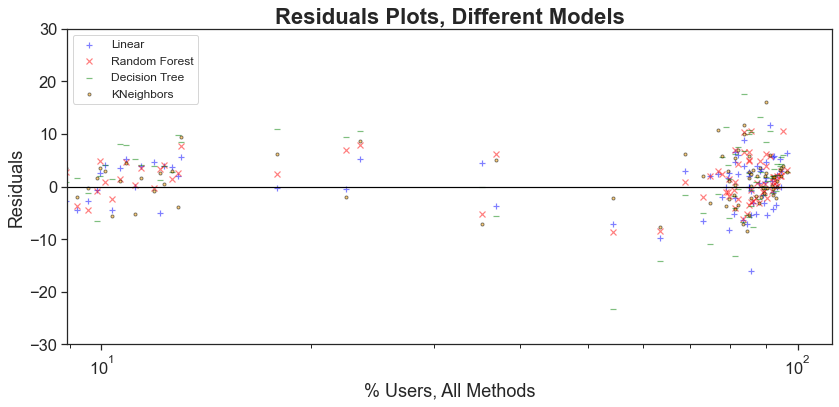

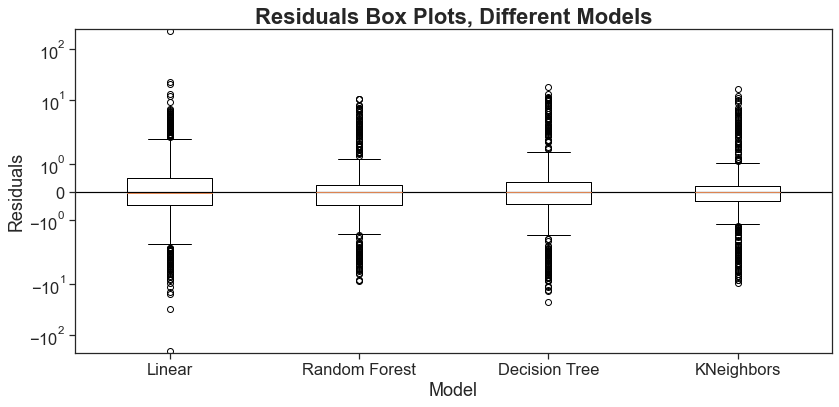

#### Comparative Scores


 **Training**

RMSE_LR  R2_LR  MAE_LR  RMSE_RF  R2_RF  MAE_RF  RMSE_DT  \
Train               2.93   0.89    2.20     2.08   0.95    1.16     0.75   
Bus                 1.40   0.87    1.03     0.80   0.96    0.54     0.72   
Ferry               0.14   0.72    0.10     0.08   0.91    0.04     0.07   
Tram                0.16   0.64    0.11     0.09   0.89    0.03     0.04   
Car                 3.13   0.95    2.38     2.60   0.97    1.51     0.76   
Motorcycle          0.19   0.83    0.15     0.11   0.94    0.08     0.20   
Bicycle             0.25   0.87    0.19     0.16   0.95    0.11     0.20   
Walk                1.50   0.79    1.17     0.91   0.93    0.66     0.74   
Uniform Average     1.69   0.82    0.92     1.25   0.94    0.52     0.54   

                 R2_DT  MAE_DT  RMSE_KN  R2_KN  MAE_KN  
Train             0.99    0.43     4.05   0.79    2.40  
Bus               0.96    0.43     1.69   0.80    1.17  
Ferry             0.92    0.03     0.19   0.46    0.07  
Tram              0.98    0.02     0.22   0.36    0.06  
Car               1.00    0.45     5.16   0.87    3.29  
Motorcycle        0.82    0.12     0.25   0.71    0.20  
Bicycle           0.92    0.11     0.36   0.74    0.22  
Walk              0.95    0.46     1.92   0.66    1.40  
Uniform Average   0.94    0.26     2.50   0.68    1.10


 **Testing**

RMSE_LR  R2_LR  MAE_LR  RMSE_RF  R2_RF  MAE_RF  RMSE_DT  \
Train              28.89 -19.20    6.97     3.05   0.77    2.30     4.13   
Bus                 5.62  -2.73    2.60     1.82   0.61    1.33     3.14   
Ferry               0.57 -10.82    0.23     0.16   0.07    0.08     0.19   
Tram                0.57 -73.97    0.27     0.11  -1.76    0.06     0.07   
Car                31.29  -8.15    8.10     4.30   0.83    3.32     7.14   
Motorcycle          0.51  -0.18    0.27     0.31   0.57    0.21     0.40   
Bicycle             2.03 -18.68    0.59     0.28   0.64    0.22     0.33   
Walk                3.08  -0.16    2.37     2.10   0.47    1.63     3.51   
Uniform Average    15.25 -16.74    2.68     2.11   0.27    1.14     3.36   

                 R2_DT  MAE_DT  RMSE_KN  R2_KN  MAE_KN  
Train             0.59    3.04     3.33   0.73    2.29  
Bus              -0.17    1.98     1.42   0.76    0.98  
Ferry            -0.24    0.09     0.17   0.00    0.08  
Tram             -0.02    0.03     0.12  -2.45    0.06  
Car               0.52    5.31     4.88   0.78    3.69  
Motorcycle        0.27    0.31     0.28   0.65    0.19  
Bicycle           0.47    0.25     0.28   0.62    0.21  
Walk             -0.49    2.53     2.32   0.35    1.76  
Uniform Average   0.12    1.69     2.31   0.18    1.16

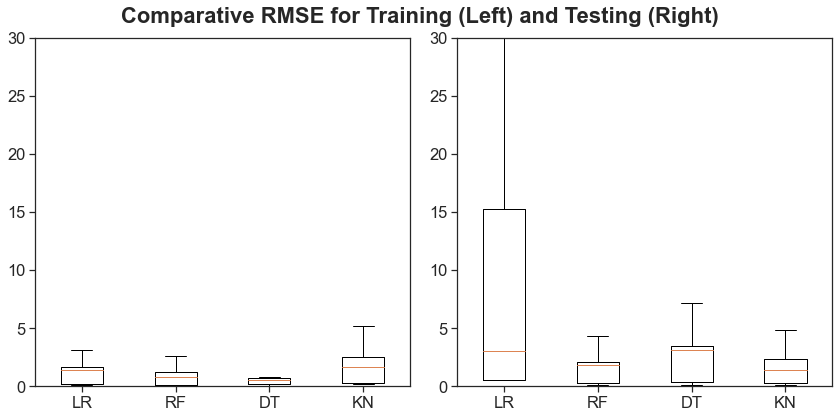

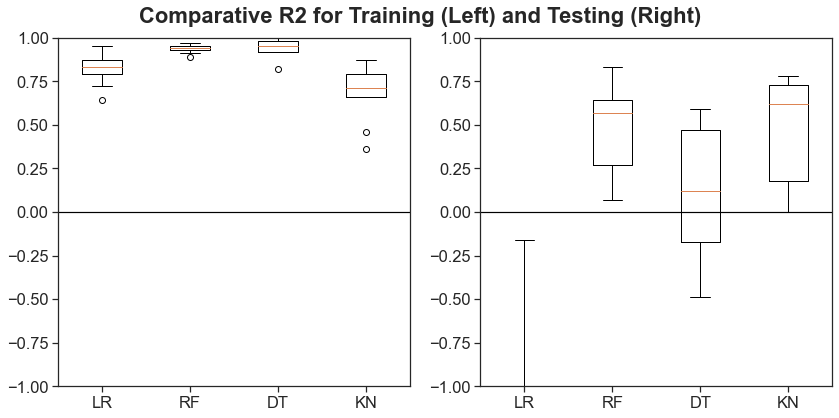

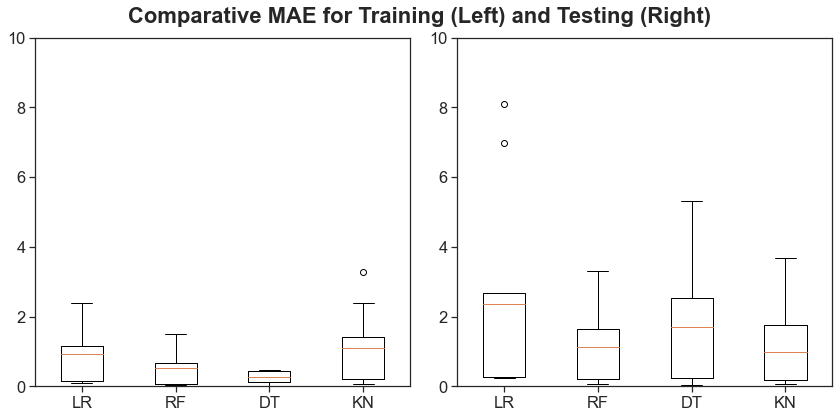

In [71]:
# comparative residual plot
plt.figure(figsize=(12,6))
plt.scatter(Y_test, allresidualsLR, color='blue', marker='+', edgecolor='black', alpha=0.5)
plt.scatter(Y_test, allresidualsRF, color='red', marker='x', edgecolor='black', alpha=0.5)
plt.scatter(Y_test, allresidualsDT, color='green', marker='_', edgecolor='black', alpha=0.5)
plt.scatter(Y_test, allresidualsKN, color='orange', marker='.', edgecolor='black', alpha=0.5)
plt.title('Residuals Plots, Different Models', fontsize=22, fontweight='bold')
plt.legend(['Linear','Random Forest','Decision Tree','KNeighbors'], loc='best', fontsize=12)
plt.axhline(0, color='black')
plt.ylim(-30,30)
plt.xscale('log')
plt.xlabel('% Users, All Methods')
plt.ylabel('Residuals')

# comparative residual box plot
plt.figure(figsize=(12,6))
plt.boxplot((allresidualsLR.flatten(),allresidualsRF.flatten(),allresidualsDT.flatten(),allresidualsKN.flatten()),labels=['Linear','Random Forest','Decision Tree','KNeighbors'])
plt.title('Residuals Box Plots, Different Models', fontsize=22, fontweight='bold')
plt.axhline(0, color='black')
plt.xlabel('Model')
plt.ylabel('Residuals')
plt.yscale('symlog')

plt.show()


scores_train = scores_LR_train.transpose().add_suffix('_LR').join(scores_RF_train.transpose().add_suffix('_RF')).join(scores_DT_train.transpose().add_suffix('_DT')).join(scores_KN_train.transpose().add_suffix('_KN'))
scores_test = scores_LR_test.transpose().add_suffix('_LR').join(scores_RF_test.transpose().add_suffix('_RF')).join(scores_DT_test.transpose().add_suffix('_DT')).join(scores_KN_test.transpose().add_suffix('_KN'))

rmses_train = scores_train[['RMSE_LR','RMSE_RF','RMSE_DT','RMSE_KN']]
rmses_test = scores_test[['RMSE_LR','RMSE_RF','RMSE_DT','RMSE_KN']]

r2s_train = scores_train[['R2_LR','R2_RF','R2_DT','R2_KN']]
r2s_test = scores_test[['R2_LR','R2_RF','R2_DT','R2_KN']]

maes_train = scores_train[['MAE_LR','MAE_RF','MAE_DT','MAE_KN']]
maes_test = scores_test[['MAE_LR','MAE_RF','MAE_DT','MAE_KN']]


printmd('#### Comparative Scores')
printmd('\n **Training**')
display(scores_train)
printmd('\n **Testing**')
display(scores_test)

f, axes = plt.subplots(1,2,figsize=(12,6))
f.suptitle('Comparative RMSE for Training (Left) and Testing (Right)', fontsize=22, fontweight='bold')
f.subplots_adjust(top=10)
axes[0].set_title(' ')
axes[0].set_ylim(0,30)
axes[0].boxplot(rmses_train.transpose(),labels=['LR','RF','DT','KN'])
axes[1].boxplot(rmses_test.transpose(),labels=['LR','RF','DT','KN'])
axes[1].set_ylim(0,30)

f, axes = plt.subplots(1,2,figsize=(12,6))
f.suptitle('Comparative R2 for Training (Left) and Testing (Right)', fontsize=22, fontweight='bold')
f.subplots_adjust(top=10)
axes[0].set_title(' ')
axes[0].set_ylim(-1,1)
axes[0].axhline(0, color='black')
axes[1].set_ylim(-1,1)
axes[1].axhline(0, color='black')
axes[0].boxplot(r2s_train.transpose(),labels=['LR','RF','DT','KN'])
axes[1].boxplot(r2s_test.transpose(),labels=['LR','RF','DT','KN'])

f, axes = plt.subplots(1,2,figsize=(12,6))
f.suptitle('Comparative MAE for Training (Left) and Testing (Right)', fontsize=22, fontweight='bold')
f.subplots_adjust(top=10)
axes[0].set_title(' ')
axes[0].set_ylim(0,10)
axes[1].set_ylim(0,10)
axes[0].boxplot(maes_train.transpose(),labels=['LR','RF','DT','KN'])
axes[1].boxplot(maes_test.transpose(),labels=['LR','RF','DT','KN'])


plt.show()

The linear model exhibited a relatively large scatter of residuals with some as far as 200%.
The other models were more constrained to within 15% but exhibited a notable fanning out of residuals with increasing utilisation percentage. 
This is likely due to a scaling of any error in the model with the actual percentage figures.
The cluster of car usage residuals is noticebly wider than the other modes of transit. 
Overall however, the middle quartiles of residuals for all four techniques fall between +1% and -1% as seen in the box plot. 
With the main difference being the scatter of the whiskers and the outliers.  

Comparing RMSE scores between training and testing data, we can see that the linear, random forest and decision techniques appear to produce overfitted models. The RMSE on the testing set  increases substantially for the linear regression and decision tree models, but less so on the random forest model. The RMSE change from the KNeighbors model is however far less noticeable.
Comparing r2 confirms that the models are overfitted. The r2 coefficients for the models are all lower on the testing set. The linear model in particular exhibits r2 of less than -1. Though notably, the median r2 value for the KNeighbours model exhibited the least reduction between training and testing.

##### Quick insights
- We can see RMSE values of Ferry, Bus, Train, and Bicycle as significant values in most regressions.
- Adjusted R squared values are significant for the above mentioned areas as well.
- Data accuracy can be concluded.
- The Mean Absolute Error tells us that the model is not without faults. This means our data is real and tampered with.

### 7.3 Model Refinement by Recursive Feature Elimination

The ferry and tram targets were obviously skewing overall average performance of the model. They are excluded for model refinement.

In [56]:
# remove tram and ferry from model
Y_train =  Y_train.drop(columns=['Tram','Ferry'])
Y_test = Y_test.drop(columns=['Tram','Ferry'])

#### 7.3.1. Recursive Feature Elimination

Linear Model 

Predictors | Training Scores            | Testing Scores             |
-----------|----------------------------|----------------------------|
       No. | RMSE     R2       MAE      | RMSE     R2       MAE      |
---------- | ------   ------   ------   | ------   ------   ------   |
         1 | 7.26     0.00     3.81     | 5.42     -0.04    2.98     |
         2 | 7.25     0.02     3.81     | 5.44     -0.02    2.98     |
         3 | 5.11     0.43     2.57     | 4.46     0.25     2.58     |
         4 | 5.09     0.44     2.55     | 4.50     0.24     2.60     |
         5 | 4.44     0.52     2.35     | 4.85     0.09     2.44     |
         6 | 4.35     0.57     2.26     | 19.67    -46.57   4.06     |
         7 | 4.35     0.57     2.25     | 19.62    -45.95   4.05     |
         8 | 4.34     0.57     2.26     | 19.07    -44.75   3.98     |
         9 | 4.34     0.57     2.25     | 19.75    -47.15   4.05     |
        10 | 4.31     0.58     2.22     | 20.28    -47.45   4.23     |
      

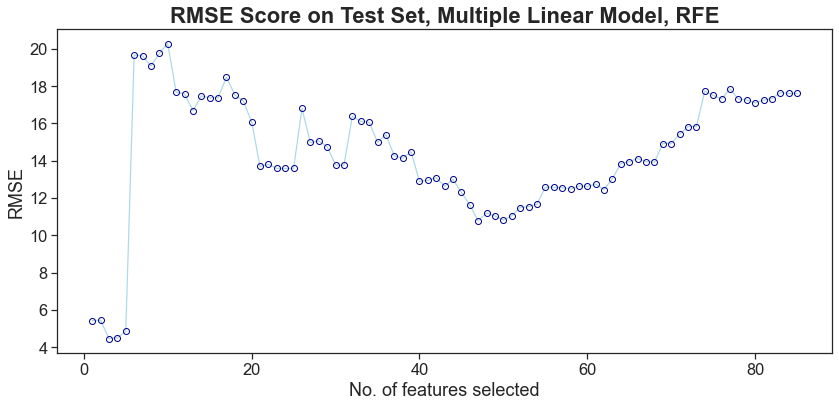

Using 3 Features: ['100+' 'Info' 'Neg']
The lowest RMSE of 4.45968465089239 was achieved.


In [47]:
# initialise vectors for scores
rmse_scores_test_LR = []
r2_scores_test_LR = []
mae_scores_test_LR = []

rmse_scores_train_LR = []
r2_scores_train_LR = []
mae_scores_train_LR = []

features_LR = []

sep = '-----------------------------------------------------'

print('%10s | %-26s | %-26s |'%('Predictors','Training Scores','Testing Scores'))
print('%.11s|%-.28s|%-.28s|'%(sep,sep,sep))
print('%10s | %-6s   %-6s   %-6s   | %-6s   %-6s   %-6s   |'%('No.','RMSE','R2','MAE','RMSE','R2','MAE'))
print('%-.10s | %-.6s   %-.6s   %-.6s   | %-.6s   %-.6s   %-.6s   |'%(sep,sep,sep,sep,sep,sep,sep))

# loop to fit linear regression model using between 1 and all features using RFE
for i in range(1,(X_train.shape[1]+1)):
    
    # set RFE selector
    selector = RFE(regLR, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, Y_train)
    
    # test model on sets
    Y_train_LR_RFE = selector.predict(X_train)
    Y_test_LR_RFE = selector.predict(X_test)
    
    # compute metrics, training set
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_LR_RFE))
    r2_train = r2_score(Y_train, Y_train_LR_RFE)
    mse_train = mean_absolute_error(Y_train, Y_train_LR_RFE)
    rmse_scores_train_LR.append(rmse_train)
    r2_scores_train_LR.append(r2_train)    
    mae_scores_train_LR.append(mse_train)
    
    # compute metric, testing set
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_LR_RFE))
    r2_test = r2_score(Y_test, Y_test_LR_RFE)
    mse_test = mean_absolute_error(Y_test, Y_test_LR_RFE)
    rmse_scores_test_LR.append(rmse_test)
    r2_scores_test_LR.append(r2_test)    
    mae_scores_test_LR.append(mse_test)
    
    # append features used
    features_LR.append(X_train.columns[selector.support_].values)
    
    print('%10d | %-6.2f   %-6.2f   %-6.2f   | %-6.2f   %-6.2f   %-6.2f   |'%(i, rmse_train, r2_train, mse_train, rmse_test, r2_test, mse_test))

print('')
plt.figure(figsize=(12,6))  
plt.xlabel('No. of features selected')
plt.ylabel('RMSE')
plt.title('RMSE Score on Test Set, Multiple Linear Model, RFE', fontsize=22, fontweight='bold')
plt.plot(range(1, len(features)+1), rmse_scores_test_LR, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Using',(rmse_scores_test_LR.index(min(rmse_scores_test_LR))+1),'Features:',features_LR[(rmse_scores_test_LR.index(min(rmse_scores_test_LR)))])
print('The lowest RMSE of',min(rmse_scores_test_LR),'was achieved.')

Random Forest Model

Predictors | Training Scores          | Testing Scores           |
-----------|--------------------------|--------------------------|
       No. | RMSE     R2      MAE     | RMSE     R2      MAE     |
---------- | ------   -----   -----   | ------   -----   -----   |
         1 | 2.03     0.91    1.02    | 4.37     0.12    2.41    |
         2 | 1.47     0.94    0.79    | 3.30     0.44    1.88    |
         3 | 1.45     0.94    0.74    | 3.32     0.44    1.91    |
         4 | 1.43     0.95    0.69    | 3.04     0.53    1.72    |
         5 | 1.43     0.95    0.69    | 3.12     0.53    1.72    |
         6 | 1.45     0.94    0.70    | 3.06     0.55    1.72    |
         7 | 1.42     0.95    0.68    | 2.86     0.57    1.65    |
         8 | 1.40     0.95    0.68    | 2.83     0.57    1.65    |
         9 | 1.46     0.95    0.69    | 2.82     0.58    1.63    |
        10 | 1.46     0.94    0.69    | 2.83     0.58    1.63    |
        11 | 1.44     0.95    0.67    | 2.59     0.59    1.54 

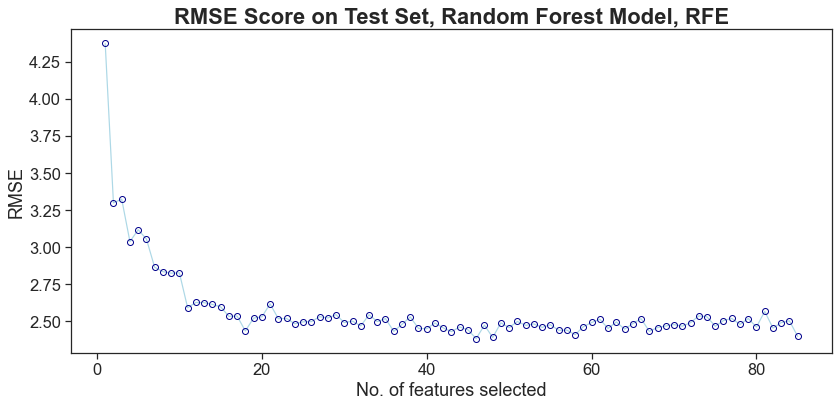

Using 46 Features: ['15-19' '20-24' '25-29' '30-34' '45-49' '50-54' '55-59' '60-64' '65-69'
 '90-94' '95-99' 'Pros' 'Admn' 'Mnfg' 'Cons' 'WsTr' 'ReTr' 'Accm' 'Lgst'
 'Info' 'Fins' 'Tech' 'Sppt' 'Hlth' 'Arts' '1-149' '0-1' '1-2.5' '2.5-5'
 '5-10' '10-20' '20-30' '30-50' '50-100' '100-250' '250+' 'CITY' 'ESUB'
 'INWS' 'NSYD' 'NBEA' 'OUSW' 'PARR' 'RYDE' 'STWS' 'SUTH']
The lowest RMSE of 2.383982147631583 was achieved.


In [57]:
# initialise vectors for scores
rmse_scores_test_RF = []
r2_scores_test_RF = []
mae_scores_test_RF = []

rmse_scores_train_RF = []
r2_scores_train_RF = []
mae_scores_train_RF = []

features_RF=[]

sep = '-----------------------------------------------------'

print('%10s | %-24s | %-24s |'%('Predictors','Training Scores','Testing Scores'))
print('%.11s|%-.26s|%-.26s|'%(sep,sep,sep))
print('%10s | %-6s   %-5s   %-5s   | %-6s   %-5s   %-5s   |'%('No.','RMSE','R2','MAE','RMSE','R2','MAE'))
print('%-.10s | %-.6s   %-.5s   %-.5s   | %-.6s   %-.5s   %-.5s   |'%(sep,sep,sep,sep,sep,sep,sep))

# loop to fit linear regression model using between 1 and all features using RFE
for i in range(1,(X_train.shape[1]+1)):
    
    # set RFE selector
    selector = RFE(regRF, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, Y_train)
    
    # test model on sets
    Y_train_RF_RFE = selector.predict(X_train)
    Y_test_RF_RFE = selector.predict(X_test)
    
    # compute metrics, training set
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_RF_RFE))
    r2_train = r2_score(Y_train, Y_train_RF_RFE)
    mse_train = mean_absolute_error(Y_train, Y_train_RF_RFE)
    rmse_scores_train_RF.append(rmse_train)
    r2_scores_train_RF.append(r2_train)    
    mae_scores_train_RF.append(mse_train)
    
    # compute metric, testing set
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_RF_RFE))
    r2_test = r2_score(Y_test, Y_test_RF_RFE)
    mse_test = mean_absolute_error(Y_test, Y_test_RF_RFE)
    rmse_scores_test_RF.append(rmse_test)
    r2_scores_test_RF.append(r2_test)    
    mae_scores_test_RF.append(mse_test)
    
    # append features used
    features_RF.append(X_train.columns[selector.support_].values)
    
    print('%10d | %-6.2f   %-5.2f   %-5.2f   | %-6.2f   %-5.2f   %-5.2f   |'%(i, rmse_train, r2_train, mse_train, rmse_test, r2_test, mse_test)) 
    
print('')
plt.figure(figsize=(12,6))
plt.xlabel('No. of features selected')
plt.ylabel('RMSE')
plt.title('RMSE Score on Test Set, Random Forest Model, RFE', fontsize=22, fontweight='bold')
plt.plot(range(1, len(features)+1), rmse_scores_test_RF, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Using',(rmse_scores_test_RF.index(min(rmse_scores_test_RF))+1),'Features:',features_RF[(rmse_scores_test_RF.index(min(rmse_scores_test_RF)))])
print('The lowest RMSE of',min(rmse_scores_test_RF),'was achieved.')

Decision Tree Model

Predictors | Training Scores          | Testing Scores           |
-----------|--------------------------|--------------------------|
       No. | RMSE     R2      MAE     | RMSE     R2      MAE     |
---------- | ------   -----   -----   | ------   -----   -----   |
         1 | 1.76     0.84    0.85    | 5.13     -0.03   2.47    |
         2 | 1.16     0.90    0.61    | 3.78     0.23    2.21    |
         3 | 1.11     0.90    0.55    | 4.01     0.26    2.22    |
         4 | 0.88     0.92    0.46    | 3.96     0.18    2.27    |
         5 | 0.89     0.92    0.46    | 4.72     -0.11   2.52    |
         6 | 0.85     0.92    0.44    | 4.12     -0.03   2.31    |
         7 | 0.85     0.92    0.44    | 4.19     -0.00   2.34    |
         8 | 0.86     0.93    0.42    | 4.20     0.07    2.22    |
         9 | 0.80     0.94    0.41    | 3.85     0.13    2.05    |
        10 | 0.78     0.94    0.40    | 3.64     0.37    2.08    |
        11 | 0.78     0.94    0.39    | 3.91     0.15    2.09 

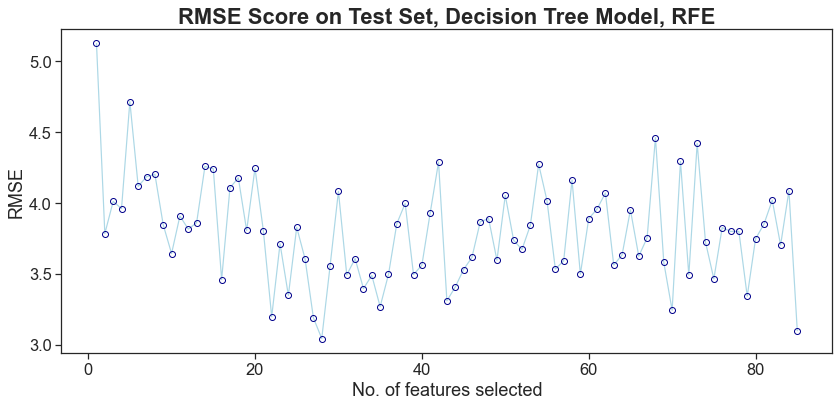

Using 28 Features: ['20-24' '25-29' '35-39' '40-44' '80-84' 'Comm' 'Admn' 'Util' 'WsTr'
 'Lgst' 'Hlth' 'Arts' '150-299' '1500-1749' '2000-2999' '0-1' '1-2.5'
 '2.5-5' '20-30' '30-50' '50-100' '100-250' 'BKTN' 'CITY' 'NSYD' 'NBEA'
 'OUSW' 'OUWS']
The lowest RMSE of 3.0429442763682935 was achieved.


In [58]:
# initialise vectors for scores
rmse_scores_test_DT = []
r2_scores_test_DT = []
mae_scores_test_DT = []

rmse_scores_train_DT = []
r2_scores_train_DT = []
mae_scores_train_DT = []

features_DT = []

sep = '-----------------------------------------------------'

print('%10s | %-24s | %-24s |'%('Predictors','Training Scores','Testing Scores'))
print('%.11s|%-.26s|%-.26s|'%(sep,sep,sep))
print('%10s | %-6s   %-5s   %-5s   | %-6s   %-5s   %-5s   |'%('No.','RMSE','R2','MAE','RMSE','R2','MAE'))
print('%-.10s | %-.6s   %-.5s   %-.5s   | %-.6s   %-.5s   %-.5s   |'%(sep,sep,sep,sep,sep,sep,sep))

# loop to fit linear regression model using between 1 and all features using RFE
for i in range(1,(X_train.shape[1]+1)):
    
    # set RFE selector
    selector = RFE(regDT, n_features_to_select=i, step=1)
    selector = selector.fit(X_train, Y_train)
    
    # test model on sets
    Y_train_DT_RFE = selector.predict(X_train)
    Y_test_DT_RFE = selector.predict(X_test)
    
    # compute metrics, training set
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_DT_RFE))
    r2_train = r2_score(Y_train, Y_train_DT_RFE)
    mse_train = mean_absolute_error(Y_train, Y_train_DT_RFE)
    rmse_scores_train_DT.append(rmse_train)
    r2_scores_train_DT.append(r2_train)    
    mae_scores_train_DT.append(mse_train)
    
    # compute metric, testing set
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_DT_RFE))
    r2_test = r2_score(Y_test, Y_test_DT_RFE)
    mse_test = mean_absolute_error(Y_test, Y_test_DT_RFE)
    rmse_scores_test_DT.append(rmse_test)
    r2_scores_test_DT.append(r2_test)    
    mae_scores_test_DT.append(mse_test)
    
    # append features used
    features_DT.append(X_train.columns[selector.support_].values)
    
    print('%10d | %-6.2f   %-5.2f   %-5.2f   | %-6.2f   %-5.2f   %-5.2f   |'%(i, rmse_train, r2_train, mse_train, rmse_test, r2_test, mse_test)) 

print('')
plt.figure(figsize=(12,6))
plt.xlabel('No. of features selected')
plt.ylabel('RMSE')
plt.title('RMSE Score on Test Set, Decision Tree Model, RFE', fontsize=22, fontweight='bold')
plt.plot(range(1, len(features)+1), rmse_scores_test_DT, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Using',(rmse_scores_test_DT.index(min(rmse_scores_test_DT))+1),'Features:',features_DT[(rmse_scores_test_DT.index(min(rmse_scores_test_DT)))])
print('The lowest RMSE of',min(rmse_scores_test_DT),'was achieved.')

##### Quick insights
- KNeighbors model does not support RFE

#### 7.3.2 Cross Validated Recursive Feature Elimination

Linear Model 

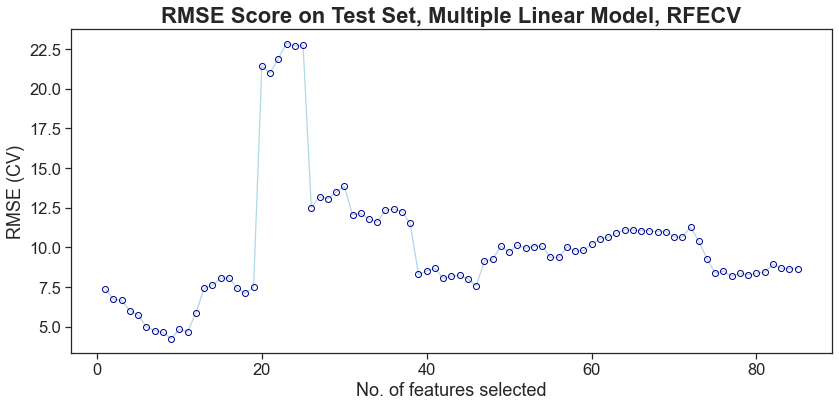

Optimal number of features : 9
Best features : ['50-54' '80-84' '90-94' '95-99' '100+' 'Mine' 'Info' 'Arts' 'Neg']
Best RMSE score: 4.830991544164418


In [59]:
# RFE Cross Validation
k = KFold(n_splits=10, shuffle=True, random_state=17)
regLR_RFECV = RFECV(estimator=regLR, step=1, cv=k, scoring='neg_mean_squared_error')
regLR_RFECV.fit(X_train, Y_train)
rmse_regLR_RFECV = np.sqrt(-regLR_RFECV.grid_scores_)

plt.figure(figsize=(12,6))  
plt.xlabel('No. of features selected')
plt.ylabel('RMSE (CV)')
plt.title('RMSE Score on Test Set, Multiple Linear Model, RFECV', fontsize=22, fontweight='bold')
plt.plot(range(1, len(regLR_RFECV.grid_scores_) + 1), rmse_regLR_RFECV, marker='o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Optimal number of features :', regLR_RFECV.n_features_)
print('Best features :', X_train.columns[regLR_RFECV.support_].values)
print('Best RMSE score:',np.sqrt(-regLR_RFECV.grid_scores_[regLR_RFECV.n_features_]))

Random Forest Model

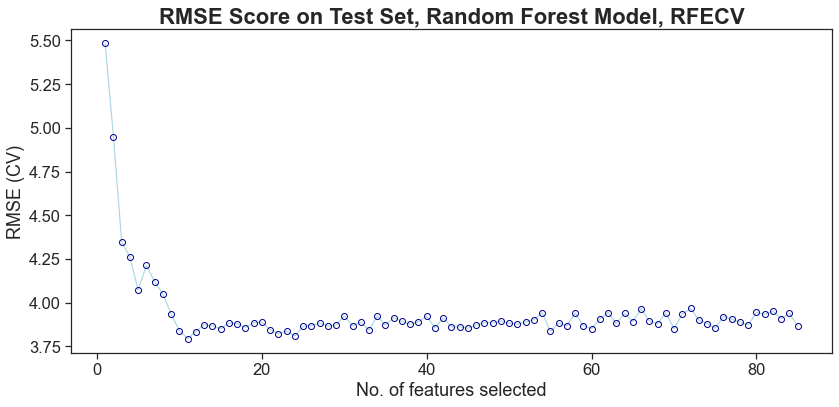

Optimal number of features : 11
Best features : ['15-19' '25-29' 'Pros' 'Mnfg' 'Cons' 'Info' '0-1' '1-2.5' '20-30' '30-50'
 'CITY']
Best RMSE score: 3.834742473315444


In [60]:
# RFE Cross Validation
k = KFold(n_splits=10, shuffle=True, random_state=17)
regRF_RFECV = RFECV(estimator=regRF, step=1, cv=k, scoring='neg_mean_squared_error')
regRF_RFECV.fit(X_train, Y_train)
rmse_regRF_RFECV = np.sqrt(-regRF_RFECV.grid_scores_)

plt.figure(figsize=(12,6))  
plt.xlabel('No. of features selected')
plt.ylabel('RMSE (CV)')
plt.title('RMSE Score on Test Set, Random Forest Model, RFECV', fontsize=22, fontweight='bold')
plt.plot(range(1, len(regRF_RFECV.grid_scores_) + 1), rmse_regRF_RFECV, marker='o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Optimal number of features :', regRF_RFECV.n_features_)
print('Best features :', X_train.columns[regRF_RFECV.support_].values)
print('Best RMSE score:',np.sqrt(-regRF_RFECV.grid_scores_[regRF_RFECV.n_features_]))

Decision Tree Model

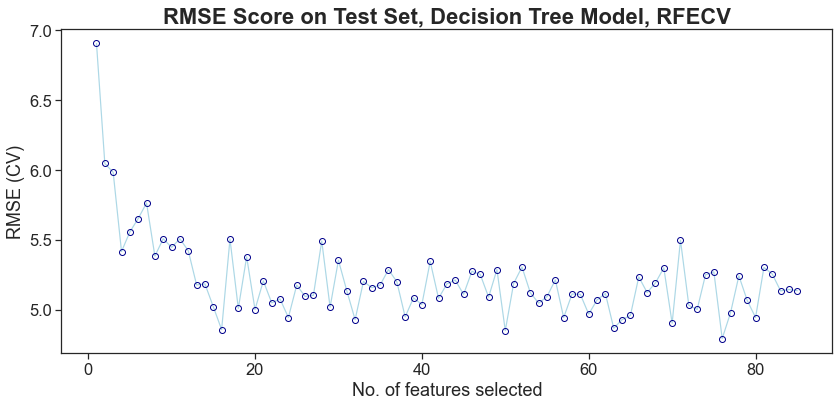

Optimal number of features : 76
Best features : ['Female' 'Male' '15-19' '20-24' '25-29' '30-34' '35-39' '40-44' '45-49'
 '50-54' '55-59' '65-69' '70-74' '75-79' '80-84' '85-89' '90-94' '100+'
 'Mgrs' 'Pros' 'Trds' 'Comm' 'Admn' 'Sale' 'Oprt' 'Lbor' 'Agri' 'Mnfg'
 'Util' 'Cons' 'WsTr' 'Accm' 'Lgst' 'Info' 'Fins' 'Rltr' 'Tech' 'Publ'
 'Hlth' 'Arts' 'Nil' '1-149' '150-299' '300-399' '400-499' '500-599'
 '650-799' '800-999' '1000-1249' '1250-1500' '1500-1749' '1750-1999'
 '2000-2999' '3000+' '0-1' '1-2.5' '2.5-5' '5-10' '10-20' '20-30' '30-50'
 '50-100' '100-250' '250+' 'BKTN' 'CITY' 'ESUB' 'INSW' 'INWS' 'NSYD'
 'NBEA' 'OUSW' 'OUWS' 'PARR' 'RYDE' 'STWS']
Best RMSE score: 4.978475689010178


In [61]:
# RFE Cross Validation
k = KFold(n_splits=10, shuffle=True, random_state=17)
regDT_RFECV = RFECV(estimator=regDT, step=1, cv=k, scoring='neg_mean_squared_error')
regDT_RFECV.fit(X_train, Y_train)
rmse_regDT_RFECV = np.sqrt(-regDT_RFECV.grid_scores_)

plt.figure(figsize=(12,6))  
plt.xlabel('No. of features selected')
plt.ylabel('RMSE (CV)')
plt.title('RMSE Score on Test Set, Decision Tree Model, RFECV', fontsize=22, fontweight='bold')
plt.plot(range(1, len(regDT_RFECV.grid_scores_) + 1), rmse_regDT_RFECV, marker='o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'DarkBlue', markerfacecolor = 'None')
plt.show()

print('Optimal number of features :', regDT_RFECV.n_features_)
print('Best features :', X_train.columns[regDT_RFECV.support_].values)
print('Best RMSE score:',np.sqrt(-regDT_RFECV.grid_scores_[regDT_RFECV.n_features_]))

##### Quick insights
- The RMSE scores provided show us indications of a severely overfit data.

***
## 8. Model Evaluation

The KNeighbor regressor and the random forest regressor recursively reduced to 46 features produced the most promising model with low average RMSEs at around 2.3%. Unfortunately, this alone is not enough to indicate a functional model. All the models seemed to overfit the training data, and no conclusion could be made with regards to feature selection. 

However these are decent first steps in this particular topic of research and there is high potential for improving the KNeighbor and random forest regressors with hyperparameter tuning. A larger pool of data may possibly improve the overall modelling process allowing for more accurate results analysis. This could be achieved by attaining transport data from all major cities across Australia as well as even exploring other important demographics such as social class, marital status and education level. 

***
## 9. Conclusions

* The overall goal for this project was to determine the effect population demographics have on the mode of transport the general populace uses. 

* Cars were the most popular form of transport both privately and overall while also encompassing the most area on the spatial visualisation chart.

* Ages between 20-40 portrays a dip in car usage. This can be explained due to traffic or lack of parking for commuters as most individuals between these ages are employed and a large proportion of them work in the city.

* Gender was found to have minimal if any correlations with choice of transport.

* Areas with population comprising of technicians and service workers were found to prioritise cars and more private transportations as compared to public transportation.

* Public transportation is favoured by people working near the Sydney CBD area. 

* People living far from the city and train lines mostly used cars or buses.

* In terms of geographic characteristics, cars were found to be used for longer distance trips while public transport was preferred for shorter distances. This helps clarify the preference for car usage in more rural/suburban areas as public transport is less prevalent further from the city. 

* As public transport and infrastructure improves in the regions around Sydney, usage of public transport may increase.